# NLP Project Sectorlense Contract checker

## 1. Introduction and Motivation

Contracts are central to the way businesses operate — especially in the Software-as-a-Service (SaaS) sector, where partnerships, licenses, and service agreements must be handled quickly and at scale. Yet despite the importance of these documents, reviewing them remains largely manual. Legal professionals are expected to carefully check that each contract contains the necessary clauses, uses appropriate wording, and meets legal and regulatory standards. This process is slow, repetitive, and mentally taxing — and the consequences of missing something can be serious: financial penalties, compliance issues, or unclear obligations.

The idea behind this project is simple: legal experts shouldn’t have to spend their time searching for whether a clause exists or whether it “sounds about right.” Instead, we wanted to test whether natural language processing tools — especially large language models (LLMs) — can help handle this first layer of review in a structured, scalable way. Not by replacing legal judgment, but by taking care of the more repetitive checks and surfacing sections that may require closer inspection.

What makes this task even more challenging is that contracts are rarely written in a standard way. Even when two documents aim to cover the same ground, the structure and phrasing can differ significantly. Many companies rely on templates, which can speed things up but also introduce gaps — especially when important clauses are accidentally left out or copied from outdated examples. Inconsistent review processes and pressure to move quickly often increase the likelihood of mistakes.

Our solution builds on a catalogue of key legal requirements — what we call “core aspects” — that are commonly expected in SaaS contracts. These include areas like data protection, liability, service levels, and termination rights. The system processes raw contract text, identifies which paragraphs might correspond to which core aspect, and then uses an LLM to assess how well that paragraph fulfills its intended function.

The overall pipeline includes:

1. **Text Cleaning** – standardizing and preparing the contract for analysis.  
2. **Clause Matching** – comparing each paragraph to the predefined core aspects using sentence embeddings.  
3. **LLM Evaluation** – asking a language model to judge whether the content of the matched paragraph actually meets the requirement, and to what degree.  
4. **Output Structuring** – collecting the results and summarizing them in a way that’s easy to interpret.

This kind of system can’t replace legal expertise — and it’s not meant to. But it can help make reviews more consistent, help surface weak or missing areas more quickly, and reduce the amount of manual work required to get a first impression of a document’s quality. For organizations that deal with a high volume of contracts, or for teams without large legal departments, this could make a real difference.

In [1]:
# ==============================================================================
#  SYSTEM & ENVIRONMENT
# ==============================================================================
import os
import sys
import ssl
import certifi
import random
import pickle
# import time
from pathlib import Path
from dotenv import load_dotenv

# SSL-Config (NLTK, Requests)
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# ==============================================================================
#  DATA HANDLING
# ==============================================================================
import pandas as pd
import numpy as np

# ==============================================================================
#  TEXT PROCESSING & NLP
# ==============================================================================
# import string
# import re
from itertools import chain

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import en_core_web_sm

from gensim.parsing.preprocessing import (
    # STOPWORDS,
    # strip_tags,
    # strip_numeric,
    # strip_punctuation,
    # strip_multiple_whitespaces,
    # remove_stopwords,
    # strip_short,
    stem_text
)

from sklearn.feature_extraction.text import CountVectorizer

# ==============================================================================
#  FILE READING & SCRAPING
# ==============================================================================
# import pdfplumber
# import docx
# import requests
# from bs4 import BeautifulSoup

# ==============================================================================
#  VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# ==============================================================================
#  MACHINE LEARNING / DEEP LEARNING
# ==============================================================================
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    roc_curve,
    auc
)
from sklearn.metrics.pairwise import cosine_similarity

# Transformers & Sentence Embeddings
from transformers import (
    BertTokenizer,
    # BertModel,
    AutoTokenizer,
    AutoModel,
    # AutoConfig
)

from sentence_transformers import SentenceTransformer, models
from sentence_transformers.models import Pooling

import inspect

# ==============================================================================
#  OPENAI API AND JSON HANDLING
# ==============================================================================
from openai import OpenAI
# import json

# Import API key from parent directory
sys.path.append(os.path.abspath(".."))
from key import OpenAiKey

# ==============================================================================
#  REPRODUCIBILITY
# ==============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==============================================================================
#  CUSTOM FUNCTIONS AND CLASSES
# ==============================================================================
# File scraping and reading
from functions.function_read_in import (  
    # scrape_html_standard,
    # scrape_html_commonpaper,
    # scrape_html_fakturia,
    # scrape_html_mitratech,
    # scrape_contract_auto,
    read_txt_file
)

# Text preprocessing
from functions.functions_preprocessing import ( 
    extract_paragraphs_and_sections,
    extract_title_fixed,
    clean_sections_and_paragraphs
)

# Embeddings
from functions.functions_embeddings import add_embed_text_column

# Core aspect evaluation
from functions.functions_criteria_fullfillment import (
    # check_core_aspects_with_llm,
    evaluate_fullfillment_on_criteria
)

# Model components
from classes.class_cosine_mapper import CosineMapper
from classes.Class_TextLabelDataset import TextLabelDataset
from classes.class_section_topic_preditcor import SectionTopicPredictor



[nltk_data] Downloading package stopwords to /Users/dave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Current working directory: /Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/notebooks


## 1. Read in Contracts

The contract checker tool that is going to be created in this project needs to be tested and trained based on some real-world example contracts. Therefore, Sectorelense provided us with an Excel sheet containing a list of various providers of SaaS solutions and links to their websites where sample contracts are available.

These contract documents appear in various formats. Some of them are in HTML, some in PDF, some in DOCX, and some in the format of JSON.

To automate the collection of contracts, our first approach was to try to build an automated scraping tool for each file format.


### Scraping HTML

In our initial implementation, we defined scraping functions for HTML websites directly in the notebook. However, to improve the structure and clarity of our final submission, these scraping functions have now been moved into external modules and are imported when needed. The logic remains unchanged: we use different scraping routines tailored to specific website structures and apply them via a dispatcher function that selects the appropriate strategy based on the URL. This setup allows for flexible extension if additional websites are to be processed later on.

Although we built scraping functions for all provided websites, our final recommendation is to extract text manually and store it in `.txt` files whenever possible. This approach proved to be faster, more reliable, and sufficient for our NLP pipeline.

### Reading in PDF, DOCX, and JSON

During development, we also considered automating the reading of documents in PDF, DOCX, and JSON formats. However, due to the large number of varying structures, we decided against fully automating this step. Writing specific parsers for each file would have introduced unnecessary complexity without clear benefits for our NLP goals. Instead, we manually converted all relevant files to `.txt` format to maintain a uniform input structure.

This pragmatic decision reflects the focus of this project: natural language processing rather than automated document scraping.

### TXT

For reading `.txt` files, a utility function was implemented. This function, too, has now been moved to an external module and is simply imported into the notebook. As a result, the code is no longer directly visible at this point in the notebook, but it continues to fulfill its role in loading text content efficiently and reliably.


### Read mapping

In this step, we load a manually created mapping table in Excel format. The original dataset only contained URLs pointing to various websites where contract texts could be found. However, for consistent processing, we created a custom mapping table.

This table links either to a URL containing the HTML content of a contract, which we aim to scrape automatically,
or to a .txt file name representing a contract we manually extracted.
The .txt files were created by us based on original documents (e.g., .docx or .pdf files). To simplify further processing and ensure a uniform data format, we converted all contracts into plain text files. This approach allows us to handle both web-based and file-based contracts in the same pipeline.

In [2]:
# Load metadata from the mapping Excel file that contains contract sources (e.g., URLs or .txt file names)
list_of_contract_meta = pd.read_excel(Path("../data/input_mapping/Mappingliste_Verträge.xlsx")) 

# Assign the metadata table to a working DataFrame named 'df' for further processing
df = list_of_contract_meta


### Add New Columns to Store Extracted Content and File Type

Before processing the contracts, we ensure that the DataFrame contains the required columns to store extracted data. Specifically, we check for two fields: one to hold the actual contract content, and another to indicate the source format of that content (e.g., whether it was extracted from a local file or scraped from a website).

Originally, this was handled manually or added ad hoc during data manipulation. To make the process more robust and ensure consistent structure when reloading or reusing the notebook, these columns are now initialized conditionally—only if they are not already present.

As the logic for distinguishing between different source formats and file types was moved to external helper functions, this part of the notebook only ensures the DataFrame remains compatible with those imported routines.


In [3]:
# Ensure that the DataFrame has columns to store the extracted contract content and file type.
# These are added only if not already present (e.g., when rerunning the notebook).

if 'Content' not in df.columns:
    df['Content'] = ""

if 'FileType' not in df.columns:
    df['FileType'] = ""


### Load Contract Content from TXT Files or HTML Sources

In this step, we extract the actual contract content for each entry in our mapping table. Originally, this logic was implemented directly in the notebook. However, for better modularization, key functionalities such as reading `.txt` files have been moved to separate modules and are now imported. Therefore, you will no longer see the function implementation here, only the function call.

For each entry, we check whether a local `.txt` file is specified. If so, we load the file using the imported `read_txt_file()` function.

If multiple file references are provided in a single mapping entry, they are concatenated into one content block. The file type is inferred from the first entry and stored in the DataFrame for later use. This step ensures that every contract has a unified representation, regardless of its source.


In [4]:
# Define base directory where local .txt contract files are stored
path_txt_contracts = Path("../data/verträge/verträge_txt")

# Iterate through the mapping table to load content for each contract
for idx, row in df.iterrows():
    mapping_field = row['Mapping']
    content = ""
    file_type = ""

    if pd.notna(mapping_field):
        # Multiple mappings are separated by semicolons (e.g., multiple file references)
        mappings = [m.strip() for m in mapping_field.split(';')]
        texts = []

        for i, mapping in enumerate(mappings):
            if mapping.endswith('.txt'):
                # Extract filename and build path
                filename = Path(mapping).name
                filepath = path_txt_contracts / filename

                # Read .txt file content
                texts.append(read_txt_file(filepath))

                # Store file type based on the first entry
                if i == 0:
                    file_type = "TXT"
            else:
                continue
                # If scraping is needed, the following code could be re-enabled:
                # texts.append(scrape_contract_auto(mapping))
                # if i == 0:
                #     file_type = "HTML"

        # Join all collected texts into a single content block
        content = "\n\n".join(texts)

    # Save content and file type in the DataFrame
    df.at[idx, 'Content'] = content
    df.at[idx, 'FileType'] = file_type

# Create a copy of the final contract list and clean up unused variables
list_of_contracts = df.copy()
del df, list_of_contract_meta, path_txt_contracts

### Translating English Contracts to German Using DeepL API

In this step, all English-language contracts are translated into German to ensure that the entire dataset is in a single language. This simplifies further processing using a monolingual NLP model and helps reduce linguistic complexity, which can lead to improved performance.

The translation is performed using the DeepL API. To use this service, you first need to create a DeepL account (either a free or a Pro version). After registering, your personal API key can be found in the account dashboard. This key should then be stored securely in a `.env` file, typically in the following format:

DEEPL_API_KEY=your_api_key_here


The API key is securely loaded using the `load_dotenv()` function. In addition, the `src` directory is appended to the Python path to allow custom modules to be imported.

For the actual translation process, the built-in `translate_dataframe()` function provided by the DeepL package is used. This function automatically translates only those rows in the DataFrame where the language is marked as `'EN'`, ensuring that already German documents remain unchanged.

It’s also important to note the limitations of the free DeepL API plan: It allows for **up to 50,000 characters per month**. If you exceed this limit, you will either need to upgrade to a paid plan or batch your translations more carefully. Therefore, it is recommended to use the available character quota wisely.

In this notebook, the translation block is commented out by default but can be easily activated if needed.

In [5]:
# Copy the contract list into 'df' for processing
df = list_of_contracts.copy()

# --- Translation pipeline (only activate if really needed/wanted) ---
# Load environment variables (e.g., DeepL API key)
# load_dotenv()

# Add src directory to path to enable custom module import
# sys.path.append(str(Path("..") / "src"))

# Import the translation function from local module
# from translate import translate_dataframe

# Translate contracts that are labeled with language 'EN'
# df = translate_dataframe(df)
# -------------------------------------------------------

# Save translated (or unchanged) contracts into a new DataFrame
list_of_contratcts_translated = df.copy()

# Clean up intermediate variables
del df, list_of_contracts

# Print resulting translated contract list
print(list_of_contratcts_translated)


                                            Kategorie  Quelle/Organisation  \
0                                Verbände / Templates    IT-Recht Hannover   
1                                Verbände / Templates      3H Solutions AG   
2                                Verbände / Templates         Common Paper   
3   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
4   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
5   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
6   Öffentlich zugängliche Verträge großer SaaS-An...               Oracle   
7   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
8   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
9                kleinere SaaS-Anbieter (Hauptgruppe)             Fakturia   
10               kleinere SaaS-Anbieter (Hauptgruppe)               Dräger   
11               kleinere SaaS-Anbieter (Hauptgruppe)           

### Save Translated Input Data as Pickle File

After loading, processing, and translating the contract data, we save the final result to disk for later reuse.

We use the `.pkl` (pickle) format, which is a common and efficient way to store Python objects such as DataFrames. This format allows us to reload the prepared dataset without repeating time-consuming or API-limited preprocessing steps (e.g., reading files, scraping web content, or translating text).

The resulting file `data_scraped_input.pkl` contains all contracts in German—either because they were originally in German or because they were translated. This file serves as the final input for downstream NLP tasks.

> **Note:** Even though all texts are now in German, contracts that were originally in English still retain the label `"EN"` in the `Sprache` column. This makes it easy to filter or analyze translated contracts separately, if needed.


In [6]:
# Define output path for saving the processed contracts as a pickle file
# output_pickle_path = Path("../data/data_scraped_input.pkl")

# Save the translated (or raw) contracts to disk for reuse in later steps
# list_of_contratcts_translated.to_pickle(output_pickle_path)

# Clean up variable(s) no longer needed
del list_of_contratcts_translated  # , output_pickle_path

## 2. Data Cleaning

### 2.1 Data Loading and Initial Structuring

In this first step, we load the dataset from the `.pkl` file generated during the input processing phase (`data_script_input`). This file contains all contract texts — either directly read from `.txt` files or extracted from HTML pages — and, where necessary, translated into German.

Each contract entry in the dataset is enriched with essential metadata, including:

- the source of the data (file or URL)
- the document type (e.g., license agreement, AGB, etc.)
- a mapping to the original source website or filename
- the language of the document (e.g., `'DE'` or `'EN'`)
- the full contract content
- the file type (`TXT` or `HTML`)

> Note: Even translated contracts remain labeled as `"EN"` in the language column. This makes it possible to distinguish between original German documents and translations, which is useful for filtered evaluations later.

This step ensures that all contracts are consistently structured and traceable back to their origin, enabling transparent and reproducible data preparation.

In [7]:
# Load the preprocessed and translated contract data from pickle file
all_contracts_content = pd.read_pickle("../data/data_scraped_input.pkl")

# Display the first few rows for inspection
display(all_contracts_content.head())

# Make a working copy of the loaded data
df = all_contracts_content.copy()

,Kategorie,Quelle/Organisation,Dokumententyp,Mapping,Sprache,Content,FileType
0,Verbände / Templates,IT-Recht Hannover,Muster SaaS-Vertrag,https://it-rechthannover.de/IT-Muster/SaaS-Ver...,DE,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...,HTML
1,Verbände / Templates,3H Solutions AG,Standard-Vertragsbedingungen SaaS,Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...,DE,Standard-Vertragsbedingungen\nSaaS- und Clouds...,TXT
2,Verbände / Templates,Common Paper,Cloud Service Agreement,https://commonpaper.com/standards/cloud-servic...,EN,1. Service\n1.1. Access and Use. During the Su...,HTML
3,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,SaaS_SAP_Service_Level_Agreement.txt,DE,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...,TXT
4,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,Saas_SAP_General_Terms.txt,DE,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...,TXT


**Example of Contract Content:**

In [8]:
# Preview the first 1000 characters of a contract
print(df.iloc[13, 5][:1000] + "...")

Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

### 2.2 Filter and Select Data

To prepare the dataset for model training, the next step involves filtering the contracts to retain only the content that is actually relevant for downstream modeling. The selection is based on specific criteria, such as including only certain provider groups like “kleinere SaaS-Anbieter (Hauptgruppe)” while potentially excluding others. In the current configuration, this restriction is optional and commented out in the code. What remains active is the filter that ensures only German-language contracts are retained, meaning only rows where the `Sprache` column is set to `DE`.

After filtering, the DataFrame is reduced to just the `content` column, keeping only the full contract text. Additionally, a simple sequential ID column named `contract` is created to uniquely identify each entry. This column is placed at the beginning of the DataFrame to ensure a clean and consistent structure for further processing.

In [9]:
# Filter the dataset to keep only relevant contracts
# Optionally: restrict to a specific category or exclude certain providers
df = df[
    # (df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") &
    (df['Sprache'] == "DE")
    # & (df['Quelle/Organisation'] != "Comarch ERP XT")
]

# Keep only the column containing the contract content
df = df.iloc[:, [5]]
df.columns = ['content']

# Add a unique contract ID column for reference
df["contract"] = range(1, df.shape[0] + 1)

# Reorder columns to: contract ID, then content
df = df[['contract', 'content']]

**Example:**

In [10]:
# Create a copy of the filtered German-only contracts
contract_contents_german_only = df.copy()
print(contract_contents_german_only.head())

# Save the DataFrame as a pickle file for fast reloading later
with open("../data/contract_contents_german_only", "wb") as f:
    pickle.dump(contract_contents_german_only, f)

# Save the same data as an Excel file for manual inspection or documentation
contract_contents_german_only.to_excel("../data/contract_contents_german_only.xlsx", index=False)

# Clean up unused variables
del df, all_contracts_content

   contract                                            content
0         1  § 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1         2  Standard-Vertragsbedingungen\nSaaS- und Clouds...
3         3  SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4         4  ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5         5  SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


### 2.3 Slicing

To enable a more granular analysis, the contract texts are no longer treated as monolithic units but instead are divided into smaller, structured segments. This segmentation step was originally implemented as a complex regular expression directly in the notebook. However, in the current version, we have refactored this logic into a reusable function named `extract_paragraphs_and_sections()`, which is now imported from an external module.

The slicing follows a two-level segmentation logic: First, each contract is split into paragraphs using typical structural markers (e.g., `§ 1`, `1.`). Within each paragraph, further segmentation is performed to extract subsections, identified by patterns like `1.1`, `(1)`, or `1.` depending on the style of the source text.

The function `extract_paragraphs_and_sections()` encapsulates this logic and returns a list of structured rows. Each row contains the contract ID, the full paragraph including its identifier, the section identifier (if available), and the actual text content of that section.

To increase flexibility, the implementation dynamically adapts to the specific structure of each contract and infers the formatting style used. This structured slicing is essential for downstream tasks such as clause classification, similarity comparison, and training NLP models for contract analysis.



#### New Structure: Paragraph and Section Granularity

After defining the `extract_paragraphs_and_sections()` function, we apply it to the filtered dataset `contract_contents_german_only` to decompose each contract into smaller, semantically meaningful segments. This enables us to work at clause-level granularity.

First, we create a copy of the filtered DataFrame to preserve the original data. Then, we apply the slicing function row-wise using `df.apply(...)`, which returns a nested list of paragraph-section dictionaries — one list per contract. Since this nested result structure is not suitable for direct processing, we flatten it into a single list using `itertools.chain.from_iterable()`. This ensures that each paragraph-section unit is transformed into one independent row.

The resulting list of dictionaries is then converted into a new DataFrame, where each row represents one contract section and includes the following metadata: the original contract ID (`contract`), the paragraph identifier (`paragraph`), the section identifier (`section`), and the full content of that section (`section_content`). 

This level of structuring is crucial for downstream tasks that operate at clause level, such as labeling, classification, or question answering.


In [11]:
# Create a working copy of the German-only contracts
df = contract_contents_german_only.copy()

# Apply custom function to extract paragraphs and sections from each contract
sections = df.apply(extract_paragraphs_and_sections, axis=1)
print(sections.head())

# Flatten the list of lists into a single list of rows
rows = list(chain.from_iterable(sections))

# Convert the structured rows into a new DataFrame
df = pd.DataFrame(rows)

0    [{'contract': 1, 'paragraph': '§ 1', 'paragrap...
1    [{'contract': 2, 'paragraph': '§ 1', 'paragrap...
3    [{'contract': 3, 'paragraph': '1.', 'paragraph...
4    [{'contract': 4, 'paragraph': '1.', 'paragraph...
5    [{'contract': 5, 'paragraph': '1.', 'paragraph...
dtype: object


===>

In [12]:
# Save the extracted paragraph and section data into a new DataFrame
contract_sections = df.copy()

# Clean up intermediate variables that are no longer needed
del df, sections, rows

# Display the first 5 rows with contract ID, paragraph, and section for inspection
display(contract_sections[["contract", "paragraph", "section"]].head(5))

,contract,paragraph,section
0,1,§ 1,1.1
1,1,§ 1,1.2
2,1,§ 1,1.3
3,2,§ 1,(1)
4,2,§ 1,(2)


### 2.4 Extracting Paragraph Titles

To derive meaningful titles from each paragraph, we define and apply a custom function called `extract_title_fixed()`, which was modularized and moved into a separate helper module. This function attempts to extract legal-style titles directly from the paragraph content using regular expressions.

Common patterns used to identify titles include typical legal markers such as numbered openings (e.g., `1.`, `§ 1`), introductory keywords (e.g., “Der”, “Ein”, “Eine”), or capitalized phrases that are often formatted as section headers. If these patterns are found, they are extracted as titles.

However, many paragraphs either lack such indicators or use inconsistent formatting. In these cases, a fallback strategy is applied. For standalone paragraphs, a short snippet from the beginning of the paragraph is extracted and used as a provisional title. For paragraphs that contain multiple subsections, the title is reconstructed by removing the full section texts from the paragraph content.

This dual approach guarantees that every paragraph receives a consistent and meaningful title, even if none was explicitly provided in the original document.

To avoid data leakage or model bias during training, we also remove the extracted title from both the `paragraph_content` and `section_content` fields.

The `extract_title_fixed()` function returns a list of titles aligned with the segmented sections in the structured DataFrame.


### 2.5 Finalize Paragraph Titles and Clean Content

After extracting paragraph titles using the `extract_title_fixed()` function, we finalize the structure of our dataset with the following steps:

First, we apply the `extract_title_fixed()` function to each `(contract, paragraph)` group using `groupby(...).apply(...)`. This assigns one title per paragraph and stores the result in a new column called `paragraph_title`.

Next, we reorder and clean the DataFrame to retain only the relevant columns in the desired order:
- `contract`
- `paragraph`
- `paragraph_title`
- `paragraph_content`
- `section`
- `section_content`

To improve clarity, we clean the extracted titles by removing formatting markers like `§ 1` or `1.` from the title strings, ensuring that they are clean and descriptive.

In order to avoid data leakage and prevent the model from memorizing titles during training, we remove the extracted `paragraph_title` from both the `paragraph_content` and `section_content` fields. This ensures that the same title does not appear redundantly within the model input.

The final result is a structured, cleaned DataFrame where each row corresponds to a legally meaningful text unit, ready for downstream analysis.


In [13]:
# Create a working copy of the structured contract sections
df = contract_sections.copy()

# Extract a title for each paragraph and assign it to a new column
# This is done per (contract, paragraph) group using the extract_title_fixed() function
df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys=False).apply(extract_title_fixed)

# Select and reorder relevant columns for downstream use
df = df[['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']]

# Clean extracted paragraph titles by removing the paragraph marker (e.g., "§ 1")
df['paragraph_title'] = df.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)

# Remove the paragraph title from the paragraph content to avoid duplication
df["paragraph_content"] = df.apply(
    lambda row: row["paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["paragraph_content"]) else '',
    axis=1
)

# Also remove the paragraph title from section content to prevent bias in further analysis
df["section_content"] = df.apply(
    lambda row: row["section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["section_content"]) else '',
    axis=1
)

# Save the cleaned structure into a new variable and clear temporary ones
contract_sections_raw = df.copy()
del df, contract_sections

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_91810/2345699967.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys=False).apply(extract_title_fixed)


**New structure**:

In [14]:
# Display the first few rows of the cleaned and structured contract sections
display(contract_sections_raw.head())

# Define the output path for saving the pickle file
output_pickle_path = Path("../data/contract_sections_raw.pkl")

# Save the structured contract sections to disk (both as pickle and Excel)
contract_sections_raw.to_pickle(output_pickle_path)
contract_sections_raw.to_excel("../data/df_contract_sections_raw.xlsx", index=False)

# Clean up variables no longer needed
del contract_sections_raw, output_pickle_path

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


### 2.6 Cleaning Function

In the next step, we focused on cleaning and normalizing the core of the dataset. For this purpose, we implemented a flexible `clean_contract_text()` function that allows us to experiment with various cleaning strategies via function parameters.

The following cleaning options are available:

- Removing all paragraph markers (e.g., “§”, “1.2”)
- Converting all text to lowercase
- Stripping HTML tags
- Removing numbers
- Removing punctuation
- Reducing multiple whitespaces to a single space
- Removing short words (e.g., ≤ 2 characters)
- Removing known stopwords (using Gensim’s stopword library)
- Applying stemming to reduce words to their root form

We tested various combinations of these cleaning options across multiple runs.

> The best results were achieved by enabling all steps **except** stemming, short-word removal, and stopword removal.  
> Stemming in particular was avoided because it tended to distort meaning, which is especially critical in legal language.  
> Stopword removal and short-word filtering were also excluded to preserve as much legal phrasing and semantics as possible.

Therefore, we adopted this configuration as our **standard cleaning pipeline** for all downstream tasks.


**Reading in the structured dataframe**

In [15]:
# Load the structured contract sections from the previously saved pickle file
contract_sections_raw = pd.read_pickle("../data/contract_sections_raw.pkl")

# Display the first few rows to verify the structure
display(contract_sections_raw.head())

# Create a working copy for further processing
df = contract_sections_raw.copy()

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


### 2.7 Applying the Cleaning Function

After defining the modular text cleaning function `clean_contract_text()`, we apply it to both the paragraph-level and section-level content fields in the structured dataset.

By default, the function converts text to lowercase, removes paragraph markers such as "§ 1" or "1.2", strips HTML tags, deletes numbers and punctuation, and collapses multiple spaces into one. These transformations are applied to two new columns: `clean_paragraph_content`, which holds the cleaned version of the full paragraph, and `clean_section_content`, which contains the cleaned version of each section inside the paragraph.

This process ensures the downstream NLP models receive clean and normalized input while retaining the original text in parallel for reference or auditing purposes.


In [16]:
# Apply text cleaning function to paragraph and section content
# This includes steps like removing punctuation, lowercasing, etc.
df["clean_paragraph_content"] = df["paragraph_content"].apply(clean_sections_and_paragraphs)
df["clean_section_content"] = df["section_content"].apply(clean_sections_and_paragraphs)

# Save the cleaned result to a new variable for downstream use
contract_sections_clean = df.copy()

# Clean up intermediate variables
del df, contract_sections_raw

**Example clean paragraph:**

In [17]:
# Print the first 150 characters of the first cleaned paragraph
print(contract_sections_clean["clean_paragraph_content"][0][:150] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infrastruktur zugänglich ist die nutzung umfasst die b...


**Example clean section:**

In [18]:
# Print the first 100 characters of the first cleaned section
print(contract_sections_clean["clean_section_content"][0][:100] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infr...


### 2.8 Visualizing Token Distributions with Word Clouds

To better understand the most frequent tokens used in our corpus, we visualize word clouds at both the paragraph and section levels. Each word cloud is based on different tokenization strategies to compare how preprocessing steps affect vocabulary representation.

The applied methods include stemming (reducing words to their roots such as “Verträge” becoming “vertrag”), lemmatization using spaCy (which extracts the canonical form of a word with grammatical context), and tokenization with transformer models. For the latter, we use both the BERT tokenizer (uncased) and the multilingual paraphrase tokenizer from the Sentence-Transformer library.

Each method is applied to both the cleaned `paragraph_content` and `section_content` columns to explore differences at different text granularities. This results in eight distinct views across paragraphs and sections.

These views help us identify the most common legal terms and examine tokenization behavior across models. They are particularly useful for understanding how English-language transformer models segment German words, sometimes in unexpected ways.

By viewing the resulting word clouds side by side, we gain intuition about token distributions and validate preprocessing quality. This also highlights the importance of choosing the right model for downstream tasks, especially in multilingual contexts.


In [ ]:
# Enable inline plotting in Jupyter
%matplotlib inline

# Load required NLP models and tokenizers
nlp = en_core_web_sm.load()
bert_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlparaphrase_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Create working copy of the cleaned dataset
df = contract_sections_clean.copy()

# --- Preprocessing: Paragraph-level ---

# Apply stemming to paragraph content
df["paragraph_content_stemm"] = df['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)

# Apply lemmatization using spaCy
df["paragraph_content_lemma"] = df['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)

# Tokenize paragraph content using BERT tokenizer (uncased)
df["paragraph_content_token_bert"] = df['clean_paragraph_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

# Tokenize paragraph content using multilingual paraphrase model tokenizer
df["paragraph_content_token_mlp"] = df['clean_paragraph_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

# --- Preprocessing: Section-level ---

# Apply stemming to section content
df["section_content_stemm"] = df['clean_section_content'].apply(
    lambda text: stem_text(text)
)

# Apply lemmatization to section content
df["paragraph_section_lemma"] = df['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)

# Tokenize section content using BERT tokenizer
df["paragraph_section_token_bert"] = df['clean_section_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

# Tokenize section content using multilingual paraphrase model tokenizer
df["paragraph_section_token_mlp"] = df['clean_section_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

# --- Word Cloud Visualization Setup ---

# Define which columns to visualize and their display names
columns_and_titles = [
    ("paragraph_content_stemm", "Paragraph – Stemmed"),
    ("paragraph_content_lemma", "Paragraph – Lemmatized"),
    ("paragraph_content_token_bert", "Paragraph – BERT Tokens"),
    ("paragraph_content_token_mlp", "Paragraph – Mulitlingual Paraphrase Tokens"),
    ("section_content_stemm", "Section – Stemmed"),
    ("paragraph_section_lemma", "Section – Lemmatized"),
    ("paragraph_section_token_bert", "Section – BERT Tokens"),
    ("paragraph_section_token_mlp", "Section – Mulitlingual Paraphrase Tokens"),
]

# Prepare individual tabs for each word cloud visualization
tab_contents = []

for col, title in columns_and_titles:
    output = widgets.Output()
    with output:
        # Join tokens for token-based columns, else join raw cleaned text
        if "token" in col:
            all_text = " ".join([" ".join(tokens) if isinstance(tokens, list) else str(tokens)
                                for tokens in df[col].dropna()])
        else:
            all_text = " ".join(df[col].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_text)

        # Plot word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Wordcloud – {title}", fontsize=16)
        plt.show()
        plt.close()

        tab_contents.append((title, output))

# Create interactive tabs for all word cloud plots
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

# Display the tab widget
display(tab_widget)

### 2.9 Saving the Cleaned Contract Dataset

This step concludes the preprocessing pipeline. After cleaning, segmenting, and enriching the contract dataset with paragraph- and section-level structures, we save the final output in two formats.

The dataset is stored as a `.pkl` file (`data_clean.pkl`) for efficient reuse in downstream processing and as an `.xlsx` file (`data_clean.xlsx`) for easy manual inspection or reporting. This ensures the cleaned data is both machine-readable and human-accessible.


In [20]:
# Define output path for saving the final cleaned dataset
file_path = '../data/contract_sections_clean.pkl'

# Save the cleaned contract sections as a pickle file for efficient reuse
contract_sections_clean.to_pickle(file_path)

# Also export the cleaned dataset as an Excel file for manual inspection or reporting
contract_sections_clean.to_excel("../data/data_clean.xlsx", index=False)

# 3. Mapping

### 3.1 Catalog Cleaning

In this step, our objective is to assign labels to as many contract sections as possible using a predefined requirement catalog. The catalog is structured around three core components: the **Paragraph Topic**, which indicates the general part of the contract the requirement relates to; the **Section Topic**, phrased as a guiding question that highlights the specific issue or aspect to be addressed; and an **Example Sentence**, which illustrates how the requirement is typically expressed in legal language using a real excerpt from a SaaS contract.

This structured format enables us to later match contract content to catalog entries based on both thematic and semantic similarity. However, before we can begin mapping the requirement catalog to our contract data, it is necessary to clean the example phrases, also referred to as reference texts, contained within the catalog. These examples must go through the same preprocessing pipeline as the contract data, including steps such as lowercasing, punctuation removal, and stopword filtering.

Only after both the contract content and catalog examples have been consistently preprocessed can we begin the label assignment process effectively.

**<=== load the raw catalogue:**

In [21]:
catalogue_raw = pd.read_excel("../data/catalogue_raw.xlsx")
display(catalogue_raw)
df = catalogue_raw.copy()

,paragraph_topic,section_topic,example
0,Projektkosten & Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,„Im Festpreis von 200.000 € sind sämtliche Lei...
1,Projektkosten & Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,„Der Kunde zahlt eine monatliche Pauschale von...
2,Projektkosten & Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,„Die Vergütung ist in drei Raten zahlbar: 30% ...
3,Projektkosten & Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",„Alle Preise verstehen sich in Euro zuzüglich ...
4,Projektkosten & Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,„Reise- und Übernachtungskosten werden nur ers...
...,...,...,...
71,Sonstige wichtige Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,„Dieser Vertrag unterliegt dem Recht der Bunde...
72,Sonstige wichtige Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,„Gerichtsstand für alle Streitigkeiten aus ode...
73,Sonstige wichtige Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",„Dieser Vertrag wird in deutscher und englisch...
74,Sonstige wichtige Klauseln,Enthält der Vertrag eine salvatorische Klausel...,„Sollte eine Bestimmung dieses Vertrages unwir...



After cleaning, the requirement catalog with the processed example sentences and the corresponding paragraph topics in a coding-friendly format is saved in two formats to support different stages of the workflow.
For manual inspection and verification, the catalog is exported as an Excel file. In addition, a serialized version is stored as a `.pkl` file, which allows for efficient loading and use in subsequent processing steps of the project pipeline.

In [22]:
# ------------------------------------------------------
# 1. Clean and preprocess text columns in the dataframe
# ------------------------------------------------------
df["example"] = df["example"].str.strip('„“"').apply(clean_sections_and_paragraphs)
df["paragraph_topic"] = df["paragraph_topic"].apply(
    lambda x: x.replace("&", 'und').strip().replace(" ","_")
)

# ------------------------------------------------------
# 2. Create a cleaned copy of the dataframe for export
# ------------------------------------------------------
catalogue_clean = df.copy()
display(catalogue_clean.head())

# ------------------------------------------------------
# 3. Persist the cleaned dataframe in multiple formats
# ------------------------------------------------------
file_path = '../data/catalogue_clean.pkl'  
catalogue_clean.to_pickle(file_path)
catalogue_clean.to_excel("../data/catalogue_clean.xlsx", index=False)

del df, catalogue_clean, catalogue_raw

,paragraph_topic,section_topic,example
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...


### 3.2 Embeddings

#### Reusable Embedding Function for Multiple Models

As we intend to experiment with various models throughout the project—each producing its own type of embeddings, we have implemented a reusable function to streamline this process. 
This function takes a dataset and a specified text column as input and appends a new column containing the embeddings generated by the selected model. By structuring it this way, we can effortlessly switch between different embedding models and preserve their outputs for subsequent analysis or model comparisons. 

The custom function `add_embed_text_column` takes a pandas DataFrame, the name of the column containing the input texts, a SentenceTransformer model, and the name of the target column as its parameters. It uses the specified model to compute embeddings based on the input column and stores the resulting vectors in the designated target column. The function can be found in the file `functions/functions_embeddings.py`.

In the code chunk, we apply thisd embedding function to both the cleaned contract sections from our corpus and the cleaned example sentences from the requirement catalog. This allows us to generate vector representations for both datasets using the same embedding model and ensures that they are directly comparable in the same vector space.

For this purpose, we use the pretrained model  `"sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"` from huggingface

We identified this model during our research and chose it based on its suitability for our contract data. 
The **`paraphrase-multilingual-MiniLM-L12-v2`** model is part of the SentenceTransformers library and is designed to generate semantically meaningful sentence embeddings across over 50 languages. It is based on a distilled MiniLM architecture, which makes it both efficient and fast, without significantly compromising performance. The model is particularly strong in capturing the semantic similarity between short text segments, making it a robust choice for our use case, where contract clauses and example sentences often vary in phrasing but share underlying meaning.

**<=== load data_clean**
**<=== load catalogue_clean**

In [23]:
# ------------------------------------------------------
# 1. Load preprocessed contract sections and catalogue
# ------------------------------------------------------
contract_sections_clean_unlabeled = pd.read_pickle('../data/contract_sections_clean.pkl')
catalogue_clean = pd.read_pickle('../data/catalogue_clean.pkl')

# Set working dataframe
df = contract_sections_clean_unlabeled

# ------------------------------------------------------
# 2. Randomly sample 600 contract sections for evaluation
# ------------------------------------------------------
random.seed(2211)
sample_indices = random.sample(range(len(df["clean_section_content"])), k=600)
df = df.iloc[sample_indices, :].copy()

# ------------------------------------------------------
# 3. Set up sentence embedding model
# ------------------------------------------------------
model_url = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_name = "multilingual_paraphrase_sentence"

# Load transformer model with max sequence length of 512
model_word_embd = models.Transformer(model_url, max_seq_length=512)

# Apply mean pooling to get sentence-level embeddings
pooling_model = models.Pooling(
    model_word_embd.get_word_embedding_dimension(),
    pooling_mode_cls_token=False,
    pooling_mode_mean_tokens=True,  #  Mean pooling is preferred for semantic similarity
    pooling_mode_max_tokens=False,
)

# Combine transformer and pooling into a full sentence embedding model
model = SentenceTransformer(modules=[model_word_embd, pooling_model])

# ------------------------------------------------------
# 4. Embed contract section content and catalogue examples
# ------------------------------------------------------
df = add_embed_text_column(
    df,
    text_column="clean_section_content",
    model=model,
    target_column="section_embeddings"
)

catalogue = add_embed_text_column(
    catalogue_clean,
    text_column="example",
    model=model,
    target_column="example_ebeddings"
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


### 3.3 Initial Labeling via Embedding Similarity *(Deprecated Due to Data Leakage)*

Our initial approach for labeling the dataset was based on calculating the cosine similarity between the embeddings of contract sections and example sentences from the requirement catalog. These embeddings were generated using the previously selected model and then reviewed manually to verify the matches. The intention was to use the resulting labels for evaluating and comparing different classification models.

As the project progressed, however, it became evident that this method introduced data leakage. Since the same embeddings were used both for assigning labels and for evaluating model performance, the results would have been biased and unreliable. To ensure the integrity of our evaluation process, we ultimately decided to abandon this labeling strategy in favor of a more robust and independent approach.

Nevertheless, for the sake of documentation and reproducibility, the original method is described here.

We applied cosine similarity to identify the most semantically similar example from the requirement catalog for each cleaned contract section. First, we kept only the relevant columns from the contract dataset and stacked the embeddings into NumPy arrays. The same was done for the cleaned catalog examples. We then computed a similarity matrix using cosine similarity between the contract section embeddings (`X`) and the example embeddings from the catalog (`Y`).

For each contract section, the index and similarity score of the best-matching catalog example were determined and stored. These results were added to the dataset along with the matched example text, section topic, and paragraph topic. This enabled us to analyze how well each contract section aligned with the predefined requirements.

To gain further insight, we printed summary statistics for the similarity scores—such as the mean, minimum, and maximum values—and highlighted the best and worst matches based on the computed scores.


In [24]:
# ------------------------------------------------------
# 1. Reduce dataframe to essential columns for matching
# ------------------------------------------------------
df = df[["contract", "paragraph", "section", "clean_section_content", "section_embeddings"]]

# ------------------------------------------------------
# 2. Compute cosine similarity between sections and examples
# ------------------------------------------------------
X = np.vstack(df["section_embeddings"].values)
Y = np.vstack(catalogue["example_ebeddings"].values)

similarity_matrix = cosine_similarity(X, Y)
similarity_percent = np.round(similarity_matrix * 100, 2)

# ------------------------------------------------------
# 3. Determine best match index and corresponding score
# ------------------------------------------------------
best_match_idx = similarity_matrix.argmax(axis=1)
best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

# ------------------------------------------------------
# 4. Enrich dataframe with matched example metadata
# ------------------------------------------------------
df[f"matched_example_index"]    = best_match_idx
df[f"similarity_percent"]       = best_match_score
df[f"matched_example_text"]     = catalogue.loc[best_match_idx, "example"].values
df[f"matched_example_topic"]    = catalogue.loc[best_match_idx, "section_topic"].values
df[f"matched_paragraph"]        = catalogue.loc[best_match_idx, "paragraph_topic"].values

# ------------------------------------------------------
# 5. Print similarity statistics and inspect edge cases
# ------------------------------------------------------
print(f"# {model_name}")
print("    mean similarity:",   df["similarity_percent"].mean())
print("    max similarity:",    df["similarity_percent"].max())
print("    min similarity:",    df["similarity_percent"].min())

# Sort and print best match example
df = df.sort_values(f"similarity_percent", ascending=False)
best_match = df.iloc[0]
print("\nBest match:")
print(f'{best_match["clean_section_content"]} \n### to ### \n{best_match["matched_example_text"]} \n### with score ### {best_match["similarity_percent"]}')

# Sort and print worst match example
df = df.sort_values(f"similarity_percent", ascending=True)
worst_match = df.iloc[0]
print("\nWorst match:")
print(f'{worst_match["clean_section_content"]} \n### to ### \n{worst_match["matched_example_text"]} \n### with score ### {worst_match["similarity_percent"]}')

# ------------------------------------------------------
# 6. Save labeled version and clean up memory
# ------------------------------------------------------
contract_sections_clean_labeled_600 = df.copy()
del df, catalogue_clean, contract_sections_clean_unlabeled

# multilingual_paraphrase_sentence
    mean similarity: 66.95322
    max similarity: 95.97
    min similarity: 22.23

Best match:
sollten einzelne bestimmungen dieses vertrags ganz oder teilweise unwirksam sein oder werden wird die wirksamkeit der übrigen bestimmungen hierdurch nicht berührt die parteien verpflichten sich für diesen fall die ungültige bestimmung durch eine wirksame bestimmung zu ersetzen die dem wirtschaftlichen zweck der ungültigen bestimmung möglichst nahekommt entsprechendes gilt für etwaige lücken dieser bedingungen 
### to ### 
sollte eine bestimmung dieses vertrages unwirksam oder undurchführbar sein oder werden bleibt die wirksamkeit der übrigen bestimmungen hiervon unberührt die parteien werden die unwirksame bestimmung einvernehmlich durch eine solche regelung ersetzen die dem wirtschaftlichen zweck der unwirksamen bestimmung am nächsten kommt 
### with score ### 95.97000122070312

Worst match:
allgemeinen geschäftsbedingungen für die comarch service produkte 

Finally, the resulting DataFrame containing the similarity-based labels was saved as `contract_sections_clean_labeled_600`, which can be seen in the following output:

In [25]:
display(contract_sections_clean_labeled_600 .sort_values(f"similarity_percent", ascending=False).head(5))
del contract_sections_clean_labeled_600 # Deadend

,contract,paragraph,section,clean_section_content,section_embeddings,matched_example_index,similarity_percent,matched_example_text,matched_example_topic,matched_paragraph
305,8,15.,15.5,sollten einzelne bestimmungen dieses vertrags ...,"[-0.0041314946, 0.096693866, -0.13690825, -0.0...",74,95.970001,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
683,16,14.,14.2,der vertrag untersteht dem recht der bundesrep...,"[-0.09444846, 0.19770819, -0.38321418, -0.1446...",71,93.180000,dieser vertrag unterliegt dem recht der bundes...,Ist die anwendbare Rechtsordnung eindeutig ver...,Sonstige_wichtige_Klauseln
142,6,4.,4.1,aufgrund dieses vertrags dürfen die parteien s...,"[-0.05984672, 0.04162008, -0.55982614, -0.0669...",35,93.180000,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit
1219,24,§ 19,19.3,sollten teile dieses vertrages ganz oder teilw...,"[-0.076217115, 0.06346369, -0.16947885, 0.0086...",74,92.820000,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
286,8,11.,11.1,die parteien verpflichten sich alle vertraulic...,"[-0.052296683, 0.086999364, -0.53502244, -0.11...",35,92.269997,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit


### 3.4 Manual Mapping

As previously discussed, the automatic labeling approach based on embedding similarity was ultimately discarded due to data leakage. To ensure the integrity of our training data, we switched to a manual labeling process, aiming to assign catalog entries to contract sections based on semantic similarity with full human oversight.

Given the time-intensive nature of this task—and the fact that we are not legal experts, even in our native language German, we were only able to manually label a total of 64 data samples. 
Another challenge we faced was the limited coverage of the requirement catalog: although our dataset includes over 1,300 contract sections, we were unable to find suitable matches for every requirement. As a result, 12 out of the 76 catalog entries remain without any corresponding training data.

Our manual labeling process involved reviewing all available contracts, initially scanning for relevant keywords to identify potential matches. Once candidate sections were identified, we carefully compared them to the examples in the requirement catalog. A label was only assigned when we were fully confident that the section semantically aligned with the intended meaning of the catalog entry.

The following table presents a selection of contract sections that were successfully mapped to their corresponding `catalog_id`, which refers to the index of the matched requirement in the catalog.

**<== load sections_labeled_manually**


In [26]:
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))

,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


The assigned `catalog_id` serves as a reference point that links each manually labeled contract section to the corresponding entry in the requirement catalog. This allows for a direct comparison between the original contract section and the expected content described in the catalog. By using the `catalog_id`, we can easily retrieve the paragraph topic, guiding question (section topic), and example sentence associated with each labeled instance:

In [27]:
catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue) + 1) # add catalog id
display(catalogue_clean.head(5))

,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


## 4. Model Comparison & Evaluation

We now move on to the selection and evaluation of suitable models for our task. In total, we selected five different models from Hugging Face, all of which are based on the Sentence Transformers framework and come with their respective tokenizers:

- `deepset/gbert-base`
- `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`
- `bert-base-uncased`
- `jinaai/jina-embeddings-v2-small-en`
- `jinaai/jina-embeddings-v2-base-de`

In addition to model selection, a crucial design decision involves choosing an appropriate **pooling strategy**. Pooling determines how token-level embeddings are aggregated into a single, fixed-size vector representing an entire contract section. Since transformer models produce a sequence of token embeddings, we must apply pooling to reduce this sequence to a single embedding suitable for downstream classification or similarity tasks.

We considered the following three pooling strategies:

### CLS Token Pooling
This method uses the embedding of the special `[CLS]` token, which is automatically prepended to the input by models like BERT. During pretraining, this token is explicitly optimized to capture sentence-level meaning for classification tasks.

**Advantage:** In models like BERT that were trained with classification objectives, the `[CLS]` token can serve as a strong global representation of the input.

### Mean Pooling
This strategy computes the average of all token embeddings, excluding padding tokens. It produces a more holistic and balanced representation of the entire text span.

**Advantage:** Particularly effective for models that were not explicitly trained using the `[CLS]` token (e.g., multilingual or paraphrase-focused models), where semantic information tends to be spread across all tokens.

### Max Pooling
Here, the maximum value is taken across all token embeddings for each embedding dimension (again excluding padding). This approach emphasizes the strongest signal for each semantic feature.

**Advantage:** Max pooling can be especially useful in long or noisy texts, where a few highly relevant words may carry most of the semantic weight. It preserves these strong signals even if they are rare within the section.
<!-- n -->
<!-- n -->
<br>

The combination of embedding model and pooling strategy directly impacts the quality and robustness of the resulting section representations. In the next step, we will evaluate these combinations to identify the most effective setup for our classification task.

## 4.1 Tokenizers and Embeddings

### Token Limit per Model
First of all we determine the maximum token length supported by each of the selected transformer models. This is an important aspect when dealing with legal texts, which often contain long sections. If a section exceeds the model’s token limit, it must be truncated or split—both of which may impact performance or semantic integrity.

To extract this information, we iterate over the list of selected models, load each model using the Hugging Face `AutoModel` interface, and access the size of its position embedding matrix. This matrix defines how many tokens the model can handle in a single input sequence.

The result is stored in a DataFrame named `max_tokens_per_model`, which lists each model alongside its maximum token capacity. This overview helps us understand the constraints of each model and guides preprocessing decisions for long contract sections.

The output table below shows the maximum token limits for each of the evaluated models:



In [28]:
# ------------------------------------------------------
# 1. Suppress transformer logging for cleaner output
# ------------------------------------------------------
from transformers import logging
logging.set_verbosity_error()

# ------------------------------------------------------
# 2. Define models and corresponding Hugging Face URLs
# ------------------------------------------------------
model_names = [
    "gbert-base",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jina-embeddings-v2-small-en",
    "jina-embeddings-v2-base-de"
]

model_urls = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de"
]

# ------------------------------------------------------
# 3. Determine max token length for each transformer model
# ------------------------------------------------------
max_tokens = []

for model_name, model_url in zip(model_names, model_urls):
    model_to_test = AutoModel.from_pretrained(model_url)
    max_len = model_to_test.embeddings.position_embeddings.weight.shape[0]
    max_tokens.append((model_name, max_len))

# ------------------------------------------------------
# 4. Create and display summary DataFrame of max token lengths
# ------------------------------------------------------
max_tokens_per_model = pd.DataFrame(max_tokens, columns=["model_name", "max_token"])
display(max_tokens_per_model)

# ------------------------------------------------------
# 5. Cleanup temporary variables to free memory
# ------------------------------------------------------
del max_tokens_per_model, max_tokens, model_to_test

,model_name,max_token
0,gbert-base,512
1,paraphrase-multilingual-MiniLM-L12-v2,512
2,bert-base-uncased,512
3,jina-embeddings-v2-small-en,8192
4,jina-embeddings-v2-base-de,8192


As we can see, the first three models—based on traditional BERT or SentenceTransformer architectures—support up to **512 tokens** per input sequence. This can be a limitation when working with long legal text sections, as truncation may lead to the loss of critical information.

In contrast, the **Jina embeddings models** support sequences of up to **8192 tokens**, making them significantly better suited for processing long-form contract content without the need for aggressive truncation or segmenting. This expanded capacity can help preserve context and improve embedding quality for lengthy inputs.

### Vocabular Analysis per Model

Since each transformer model uses its own tokenizer with a distinct vocabulary and tokenization strategy, the number of tokens generated from the same input text can vary significantly between models. To better understand how each model processes our contract sections, we perform a tokenization analysis across all selected models.

First, we load the cleaned contract sections from the dataset and prepare tokenizers for each model using Hugging Face's `AutoTokenizer`. Then, for each contract section, we calculate how many tokens are generated by each tokenizer.

This analysis allows us to evaluate how "efficiently" each model represents legal text. Models that produce a higher number of tokens per section may reach their token limit sooner and require truncation more frequently. Conversely, models that produce fewer tokens for the same input are more space-efficient and can capture longer contexts without loss of information.

By comparing token lengths across models, we gain important insights into potential preprocessing needs and can better align model choice with the characteristics of our dataset.



In [29]:
# ------------------------------------------------------
# 1. Load and copy the cleaned contract section dataset
# ------------------------------------------------------
contract_sections_clean = pd.read_pickle('../data/contract_sections_clean.pkl')
df = contract_sections_clean.copy()

# ------------------------------------------------------
# 2. Load tokenizers for each selected language model
# ------------------------------------------------------
tokenizers = {}
for name, url in zip(model_names, model_urls):
    tokenizers[name] = AutoTokenizer.from_pretrained(url)

# ------------------------------------------------------
# 3. Tokenize all contract sections and record token lengths
# ------------------------------------------------------
token_counts = {}

for name, tokenizer in tokenizers.items():
    token_counts[name] = df["clean_section_content"].fillna("").apply(
        lambda x: len(tokenizer.tokenize(x))
    )


The following diagram shows how many tokens the various language models generate for the texts in our dataset. It is clearly noticeable that English-based models tend to produce a higher token density, especially for longer texts. A likely reason for this is that German words are not well represented in the English vocabulary, which leads to more frequent splitting into subword tokens.

The two models **`bert-base-uncased`** and **`jina-embeddings-v2-small-en`** consistently generate a higher number of tokens per section compared to German-language models such as **`gbert-base`** and **`jina-embeddings-v2-base-de`**.

Nevertheless, all models, including the English-based ones, perform reliably well. The fact that many contract sections exceed the token limit of certain models (e.g., 512 tokens for BERT-based architectures) is not a critical issue in our case, as we apply appropriate truncation or segmentation strategies during preprocessing.

In summary, the results suggest that **language-specific models** are more efficient and better suited for processing texts in their respective languages. In the context of our dataset, which includes over 1,300 German contract sections, models such as **`gbert-base`**, **`jina-embeddings-v2-base-de`**, and the **multilingual `paraphrase-multilingual-MiniLM-L12-v2`** demonstrate particular effectiveness by requiring fewer token splits and capturing German linguistic structure more naturally.


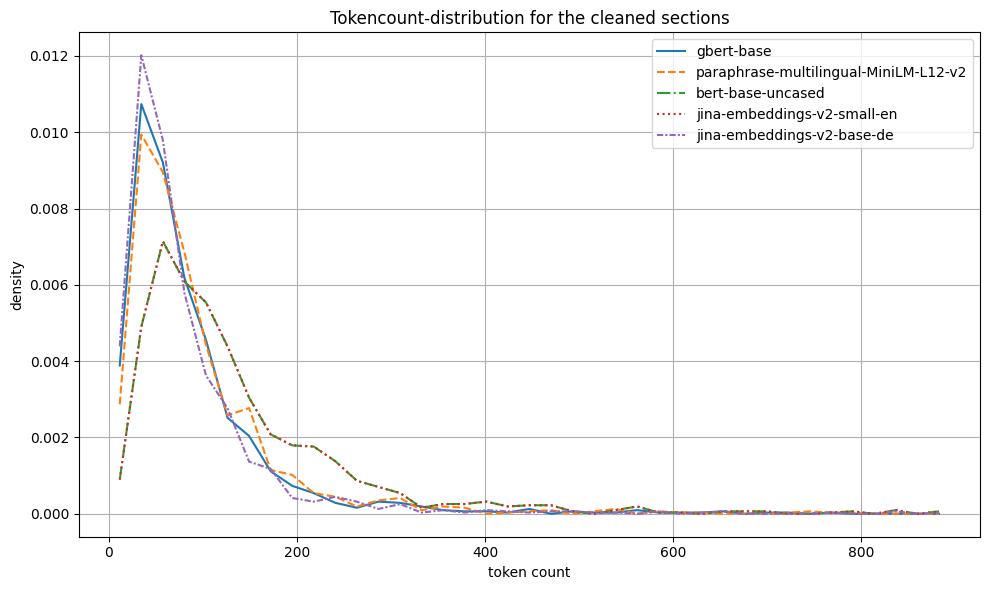

In [30]:
# ------------------------------------------------------
# 5. Plot distribution of token counts across models
# ------------------------------------------------------
plt.figure(figsize=(10, 6))

# Define histogram bins based on 99th percentile across all models
max_x = max(token_counts[name].quantile(0.99) for name in token_counts)
bins = np.linspace(0, max_x, 40)

# Define different line styles for visual distinction
styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

# Plot density histograms per model
for (name, data), style in zip(token_counts.items(), styles):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist, label=name, linestyle=style)

# Set plot titles and labels
plt.title("Tokencount-distribution for the cleaned sections")
plt.xlabel("token count")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 6. Cleanup temporary variables to free memory
# ------------------------------------------------------
del max_x, df, bins, styles, hist, bin_centers, bin_edges, token_counts, tokenizers


### 4.2 Model Assembly and Pooling Setup

In this section, we load the transformer-based language models (including their tokenizers) for our selection and prepare them for integration with the Sentence Transformers framework. Each model is paired with a defined pooling strategy to generate fixed-size sentence or section embeddings suitable for downstream tasks.

To assemble the models, we use the modular structure of Sentence Transformers, combining a `Transformer` backbone with a `Pooling` layer. This allows us to control how token-level outputs are aggregated. Each resulting configuration is stored in a dictionary called `models_dict`, using a key that reflects the specific model and pooling strategy—for example: `base_gbert_sentence_cls`.

To optimize resource usage, especially when working with limited RAM, the assembled models can optionally be saved locally after the first load. This avoids repeated downloads from Hugging Face in future runs. However, due to their size, these saved model directories should be excluded from the version control system (e.g., `.gitignore`), as they are too large for Git repositories.

This flexible setup enables us to benchmark a total of **15 different transformer model and pooling strategy combinations** in a consistent and reproducible way. These embeddings form the basis for semantic similarity tasks such as contract section classification or matching to requirement catalog entries.



In [31]:
# ------------------------------------------------------
# 1. Define model output names and pooling strategies
# ------------------------------------------------------
models_store_as = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean", "max"]

# ------------------------------------------------------
# 2. Prepare dictionaries to store models and metadata
# ------------------------------------------------------
models_dict = {}
models_urls = {}
models_strat = {}

# ------------------------------------------------------
# 3. Assemble all model + pooling strategy combinations
# ------------------------------------------------------
for model_in, model_out in zip(model_urls, models_store_as):
    # Load word embedding model with max sequence length of 512
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Assable model: {model_out}, with word-embedding-odel: '{model_in}' and pooling strategy: {pool_strat}")

        # Configure pooling strategy
        cls  = pool_strat == "cls"
        mean = pool_strat == "mean"
        maxi = pool_strat == "max"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=maxi,
        )

        # Combine embedding and pooling into final SentenceTransformer model
        model_section_embedding = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Construct key and store in model dictionaries
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model_section_embedding
        models_urls[dict_key] = model_in
        models_strat[dict_key] = pool_strat

        # --------------------------------------------------
        # Optional: Save the model to disk for later use
        # --------------------------------------------------
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# ------------------------------------------------------
# 4. Print list of successfully loaded model keys
# ------------------------------------------------------
print("loaded:", list(models_dict.keys()))

Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: cls
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: mean
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: max
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: cls
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: mean
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: max
Assable model: bert_base_uncased_sentence, with word-embedding-odel: 'bert-base-uncased' and pooling strategy: cls
Assable model: bert_base_uncased_sentence, with word-embedding-odel

### 4.3 Model Evaluation via Cosine Similarity

To evaluate the performance of each model and pooling combination, we use a similarity-based classification approach. Specifically, we let each assembled model generate embeddings for both the manually labeled contract sections (our test dataset) and the example entries in the requirement catalog.

Using **cosine similarity**, each model attempts to predict the correct label for each contract section by selecting the most similar requirement catalog entry based on the generated embeddings. These predicted labels are then compared to the ground truth labels from our manually annotated dataset.

Before performing this evaluation, we first reload the manually labeled dataset to ensure we are working with the most up-to-date and cleaned version of the data.


For evaluation purposes, we split our dataset into two parts:

**1. Labeled Data:** This subset contains only those contract sections for which a manual label (i.e., a `catalog_id`) exists. It serves as our test set for evaluating model performance through cosine similarity. These are the reference examples for which we know the correct outcome.

 
**2. Unlabeled Data:** This subset includes all remaining contract sections without any manually assigned label. While these entries are not used for model evaluation, they remain important for potential use in semi-supervised learning, inference, or downstream applications once the models have been validated.

**<=== load ciontract_sections_labeled_manually**

In [32]:
df = contract_sections_clean_labeled_manually.copy()

# ------------------------------------------------------
#  Extract only structural and content-related columns (drop labels)
# ------------------------------------------------------
df_no_label = df[["contract","paragraph","section","clean_section_content"]].copy()

display(df_no_label)

,contract,paragraph,section,clean_section_content
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...
2,4,3.,3.2,support und sla sap erbringt support für den c...
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...
...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...


In [33]:
# ------------------------------------------------------
#  Extract columns including ground-truth label (catalog ID)
# ------------------------------------------------------
df_true_label = df[["contract","paragraph","section","clean_section_content","catalog_id"]].copy()
df_true_label.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)

display(df_true_label)

,contract,paragraph,section,clean_section_content,true_catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


asdfcadyx 

In [34]:
# ------------------------------------------------------
# Ensure ground-truth catalog ID is of integer type
# ------------------------------------------------------
df_true_label["true_catalog_id"] = df_true_label["true_catalog_id"].astype(int)

# ------------------------------------------------------
# Define relevant content columns for downstream usage
# ------------------------------------------------------
cols = ["contract", "paragraph", "section", "clean_section_content"]

display(catalogue_clean)

del df

,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,dieser vertrag unterliegt dem recht der bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,gerichtsstand für alle streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",dieser vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,sollte eine bestimmung dieses vertrages unwirk...,75


### 4.4 Model Comparison and Evaluation Workflow

In this section, we want to compare the 15 models according to their classification performance by matching the contract sections to the most relevant catalog entries using **vector-based semantic similarity**. 
To keep the scope of this report focused and concise, we limit our interpretation and discussion of results to the model that achieved the best overall performance in our evaluation which is the **`paraphrase-multilingual-MiniLM-L12-v2`** with **mean pooling**. While other models were tested and compared, detailed interpretation of their individual behaviors is intentionally omitted here.

For each embedding model included in our comparison, we follow a standardized evaluation pipeline consisting of the following steps:

#### 1. Embedding Generation
We encode the `clean_section_content` from the contract sections and the `example` texts from the requirement catalog using the selected embedding model. This results in two sets of embeddings, one for the contract sections and one for the catalog entries.

#### 2. Similarity Computation
Next, we compute the **cosine similarity** between each section embedding and all catalog entry embeddings. For each contract section, we identify the catalog entry with the highest similarity score and treat it as the predicted label.

#### 3. Ground Truth Comparison
We then compare the predicted catalog ID to the manually assigned label (`true_catalog_id`) in our test dataset. This allows us to assess whether the model was able to correctly identify the intended catalog entry.

#### 4. Evaluation with ROC Curve
To evaluate the model's ability to distinguish correct from incorrect matches, we use the cosine similarity scores as confidence values and compute an **ROC curve** along with the **AUC (Area Under Curve)** score.

#### 5. Threshold Optimization
Using the ROC curve, we determine an optimal similarity threshold based on the formula  
**max(TPR - 0.5 × FPR)**. This metric balances the trade-off between true positive rate (TPR) and false positive rate (FPR), but gives slightly more weight to avoiding false positives.

We apply this threshold to classify each prediction as either **valid** (similarity above threshold) or **invalid** (below threshold).
This step is particularly important because we aim to build a **confident and conservative model**, where the cost of assigning an incorrect match (false positive) is considered lower than missing a correct match (false negative).

#### 6. Postprocessing
Predictions with similarity scores below the threshold are marked as invalid by assigning a placeholder catalog ID of `-99`. This step ensures that low-confidence predictions can be filtered out in subsequent analyses.

<br>

This evaluation pipeline is repeated for each model and pooling combination in our benchmark set. The resulting scores and classification outcomes allow us to directly compare the effectiveness of each embedding strategy and identify the model best suited for semantic matching of contract sections.


In [35]:
# ------------------------------------------------------
# 1. Initialize result containers and copy input data
# ------------------------------------------------------
models_thresholds = {}
tab_contents = []
df = df_no_label.copy()
df_cols = ["contract", "paragraph", "section", "clean_section_content"]

# ------------------------------------------------------
# 2. Iterate over all model + pooling strategy combinations
# ------------------------------------------------------
for model_name in models_dict:
    model_selected = models_dict[model_name]

    # Embed contract sections using selected model
    df = add_embed_text_column(
        df,
        text_column="clean_section_content",
        model=model_selected,
        target_column=f"section_em_{model_name}"
    )

    # Embed catalogue examples using same model
    cat = add_embed_text_column(
        catalogue_clean,
        text_column="example",
        model=model_selected,
        target_column="emb"
    )

    df_cols.append(f"section_em_{model_name}")

    # --------------------------------------------------
    # 3. Compute cosine similarity between contract sections and catalogue
    # --------------------------------------------------
    X = np.vstack(df[f"section_em_{model_name}"].values)
    Y = np.vstack(cat["emb"].values)

    similarity_matrix = cosine_similarity(X, Y)
    similarity_percent = np.round(similarity_matrix * 100, 2)

    # --------------------------------------------------
    # 4. Extract best match per section based on similarity score
    # --------------------------------------------------
    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Append match results as new columns
    new_cols = pd.DataFrame({
        f"matched_example_index_{model_name}": best_match_idx,
        f"similarity_percent_{model_name}": best_match_score,
        f"matched_example_text_{model_name}": cat.loc[best_match_idx, "example"].values,
        f"matched_example_topic_{model_name}": cat.loc[best_match_idx, "section_topic"].values,
        f"matched_paragraph_{model_name}": cat.loc[best_match_idx, "paragraph_topic"].values,
        f"matched_catalog_id_{model_name}": cat.loc[best_match_idx, "catalog_id"].values,
    })

    df = pd.concat([df.reset_index(drop=True), new_cols.reset_index(drop=True)], axis=1)
    del new_cols

    # --------------------------------------------------
    # 5. Evaluate match performance using ROC and AUC
    # --------------------------------------------------
    df_pred_label = df
    y_true = (df_true_label["true_catalog_id"].values == df_pred_label[f"matched_catalog_id_{model_name}"].values).astype(int)

    if np.sum(y_true) == 0:
        print(f"No match found at all with model: {model_name}")

    y_scores = df_pred_label[f"similarity_percent_{model_name}"].values / 100  # Normalize to [0, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Select optimal threshold: maximize (TPR - 0.5 * FPR)
    custom_score = tpr - 0.5 * fpr
    optimal_idx = np.argmax(custom_score)
    optimal_threshold = thresholds[optimal_idx]

    # --------------------------------------------------
    # 6. Visualize ROC curve and mark optimal threshold
    # --------------------------------------------------
    output = widgets.Output()
    with output:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f"Optimal Threshold: {optimal_threshold:.4f}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        tab_contents.append((model_name, output))

    # --------------------------------------------------
    # 7. Apply optimal threshold to validate matches
    # --------------------------------------------------
    df[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df.loc[~df[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    models_thresholds[model_name] = optimal_threshold

    # Cleanup per-model evaluation variables
    del y_true, y_scores

# ------------------------------------------------------
# 8. Display interactive ROC plots per model in tab view
# ------------------------------------------------------
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)
display(tab_widget)

# ------------------------------------------------------
# 9. Save results and cleanup temporary variables
# ------------------------------------------------------
matches_all_models = df.copy()
del df, df_cols, df_pred_label, optimal_threshold, optimal_idx
del fpr, tpr, thresholds, tab_widget, X, Y
del similarity_matrix, similarity_percent, best_match_idx, best_match_score

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.66it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


The ROC curve for `multilingual_paraphrase_sentence_mean` shows an AUC of 0.64, indicating a moderate ability to distinguish correct from incorrect catalog matches.

The red point represents the optimal threshold of **0.5818**, which maximizes the metric **TPR − 0.5 × FPR**. At this point, the model achieves nearly perfect recall (TPR ≈ 1.0), but at the cost of a relatively high false positive rate (FPR ≈ 0.83).

This threshold favors recall over precision, meaning that more candidate matches are accepted—at the risk of including incorrect ones. For exploratory tasks or manual validation workflows, this trade-off may be acceptable or even desirable.
### 4.5 Classification Performance: Weighted Recall Evaluation

In this step, we assess the classification performance of each model by comparing the predicted `catalog_id` values against the ground truth labels from our manually labeled dataset.

For each model in our benchmark set, we calculate the **weighted recall**, which takes into account the support (number of true instances) for each class. 

We iterate through all models, compute their classification reports using `sklearn`, and store the results in a set of interactive tabs for easy comparison. Each tab contains a full classification report—including precision, recall, and F1-score—for one model.

Finally, we determine which model achieves the **highest weighted recall** and identify it as a leading candidate for further fine-tuning or deployment.

This evaluation gives us a detailed view of model behavior across all catalog categories and helps us choose the embedding strategy that best preserves class-specific semantic distinctions.


In [36]:
# ------------------------------------------------------
# 1. Copy prediction results and suppress unnecessary warnings
# ------------------------------------------------------
df = matches_all_models.copy()

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

df = matches_all_models.copy()

# ------------------------------------------------------
# 2. Evaluate each model using weighted recall and display classification reports
# ------------------------------------------------------
tabs = []
titles = []
recalls_weighted = []

for model_name in models_dict:
    pred_col = f"matched_catalog_id_{model_name}"
    y_true = df_true_label["true_catalog_id"]
    y_pred = df[pred_col]

    # Compute weighted recall for model performance comparison
    recall_w = recall_score(y_true, y_pred, average='weighted')
    recalls_weighted.append(recall_w)

    # Create classification report tab output
    output = widgets.Output()
    with output:
        print(f"Classification Report for {model_name}")
        print(classification_report(y_true, y_pred, digits=2))

    tabs.append(output)
    titles.append(model_name)

# ------------------------------------------------------
# 3. Identify model with best weighted recall (optional use)
# ------------------------------------------------------
best_recall_idx = int(max(range(len(recalls_weighted)), key=lambda i: recalls_weighted[i]))

# ------------------------------------------------------
# 4. Display classification reports in interactive tabs
# ------------------------------------------------------
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)

# ------------------------------------------------------
# 5. Cleanup of intermediate variables to free memory
# ------------------------------------------------------
del df, tabs, titles, pred_col, y_true, y_pred
del tab_widget, recalls_weighted, model_name, output, best_recall_idx, i, title


The classification reports show that the model **`paraphrase-multilingual-MiniLM-L12-v2`** consistently outperforms the other candidates. It achieves the **highest weighted recall** as well as the **highest weighted F1-score** across all classes.

This confirms the model's strong ability to generalize across different section types and match them accurately to the appropriate catalog entries. Its multilingual architecture likely contributes to this robustness, as it is designed to handle diverse linguistic patterns—including those found in German legal texts—without sacrificing performance.

Based on these results, `paraphrase-multilingual-MiniLM-L12-v2` emerges as the most promising choice for semantic contract section classification in our setup.


### 4.6 Visual Evaluation: Confusion Matrices

To gain a deeper understanding of how each model performs across individual catalog categories, we visualize the **confusion matrices** for all evaluated models. These matrices provide insight into the types of errors each model makes—specifically, which catalog IDs are most often confused with one another.

For every model, we generate a confusion matrix using the predicted and true `catalog_id` values. To ensure consistency across models, we use a shared and sorted label space. This guarantees that axes are aligned, allowing for easier cross-model comparison.

This form of visual inspection is particularly useful to:

- Identify dominant misclassification patterns,
- Detect classes that are systematically over- or under-predicted,
- Assess whether a model is overly biased toward frequent labels.

These insights complement the numerical evaluation metrics (e.g. F1-score, recall) and provide a more nuanced view of model behavior in a real-world semantic matching scenario.


In [37]:
# ------------------------------------------------------
# 1. Prepare for confusion matrix visualization per model
# ------------------------------------------------------
tab_contents = []
df = matches_all_models.copy()

# ------------------------------------------------------
# 2. Generate confusion matrices for each model's predictions
# ------------------------------------------------------
for model_name in models_dict:
    output = widgets.Output()
    with output:
        # Extract predicted and true labels for the current model
        df_matched_ids = df[["contract", "paragraph", "section", "clean_section_content", f"matched_catalog_id_{model_name}"]]
        y_true = df_true_label["true_catalog_id"].astype(str)
        y_pred = df[f"matched_catalog_id_{model_name}"].astype(str)

        # Collect all unique labels across y_true and y_pred
        all_labels_set = set(y_true).union(set(y_pred))
        all_labels = [str(x) for x in sorted(map(int, all_labels_set))]

        # Compute confusion matrix with consistent label order
        cm = confusion_matrix(y_true, y_pred, labels=all_labels)

        # Plot the confusion matrix as heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    
    tab_contents.append((model_name, output))

# ------------------------------------------------------
# 3. Create interactive tab widget to display all matrices
# ------------------------------------------------------
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)

# ------------------------------------------------------
# 4. Clean up temporary variables
# ------------------------------------------------------
del df, tab_contents

The visualizations confirm once again that the model **`paraphrase-multilingual-MiniLM-L12-v2`** delivers the most accurate classification results. Its confusion matrix shows clearly structured predictions with minimal noise, and it very rarely assigns the placeholder label `-99`, which we use to mark uncertain or low-confidence predictions.

Moreover, many of the model's incorrect predictions are only slightly off—that is, the predicted label lies directly next to the correct one. Since the requirement catalog is thematically grouped, such near-miss errors are generally less critical and can often still be interpreted as semantically close matches.

In contrast, other models not only produce a higher number of incorrect predictions but also tend to confuse unrelated categories, resulting in more severe classification errors. This further supports the robustness of the multilingual model and underlines its suitability for our contract analysis task.

### 4.7 Summary Table and Export of Evaluation Results

The most important evaluation metric including **recall**, **accuracy**, and **F1-score** (both macro and weighted) are compiled for all 15 model and pooling combinations and presented in a single summary table. To facilitate direct comparison, the table is **sorted in descending order by weighted recall**, as this metric most closely reflects our goal of correctly capturing as many relevant matches as possible.

In addition to performance metrics, the table also includes:
- the Hugging Face model identifier (`model_url`),
- the pooling strategy used (`pooling_strategy`),
- and the optimal similarity threshold determined during ROC analysis (`optimal_threshold`).

This consolidated dataset is stored in two formats for further analysis and documentation:
- as a **`.pkl` file** for use in subsequent modeling steps, and
- as a **`.xlsx` file** for easy inspection, reporting, and sharing.

This table forms the basis for selecting the most suitable model for downstream use and helps trace the rationale behind the final choice.



In [38]:
# ------------------------------------------------------
# 1. Collect performance metrics for each model
# ------------------------------------------------------
metrics = []
df = matches_all_models.copy()

for model_name in models_dict:
    y_pred = df[f"matched_catalog_id_{model_name}"]
    y_true = df_true_label["true_catalog_id"]

    # Compute classification metrics
    metrics.append({
        "model": model_name,
        "recall (macro)": recall_score(y_true, y_pred, average='macro'),
        "recall (weighted)": recall_score(y_true, y_pred, average='weighted'),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average='macro'),
        "F1 (weighted)": f1_score(y_true, y_pred, average='weighted')
    })

# ------------------------------------------------------
# 2. Create summary DataFrame and merge with model metadata
# ------------------------------------------------------
df = pd.DataFrame(metrics).sort_values("recall (weighted)", ascending=False)

# Convert metadata dictionaries to DataFrames
thresholds = pd.DataFrame(models_thresholds.items(), columns=["model", "optimal_threshold"])
models_urls = pd.DataFrame(models_urls.items(), columns=["model", "model_url"])
models_pooling = pd.DataFrame(models_strat.items(), columns=["model", "pooling_strategy"])

# Merge metrics with model details
df = (
    df
    .merge(models_urls, on="model", how="left")
    .merge(models_pooling, on="model", how="left")
    .merge(thresholds, on="model", how="left")
)

# ------------------------------------------------------
# 3. Display and persist model comparison results
# ------------------------------------------------------
display(df)

best_models = df.copy()
best_models.to_pickle("../data/best_models.pkl")
best_models.to_excel("../data/best_models.xlsx")

# ------------------------------------------------------
# 4. Cleanup temporary variables
# ------------------------------------------------------
del metrics, df, y_pred, y_true, thresholds, model_urls, models_pooling, best_models


,model,recall (macro),recall (weighted),Accuracy,F1 (macro),F1 (weighted),model_url,pooling_strategy,optimal_threshold
0,multilingual_paraphrase_sentence_mean,0.353846,0.375000,0.375000,0.299487,0.325000,sentence-transformers/paraphrase-multilingual-...,mean,0.5818
1,multilingual_paraphrase_sentence_max,0.235294,0.265625,0.265625,0.192437,0.225298,sentence-transformers/paraphrase-multilingual-...,max,0.8587
2,base_gbert_sentence_mean,0.224638,0.250000,0.250000,0.187716,0.212798,deepset/gbert-base,mean,0.7840
3,multilingual_paraphrase_sentence_cls,0.171875,0.187500,0.187500,0.153646,0.169271,sentence-transformers/paraphrase-multilingual-...,cls,0.8052
4,base_gbert_sentence_max,0.161765,0.171875,0.171875,0.133333,0.141667,deepset/gbert-base,max,0.9375
5,bert_base_uncased_sentence_max,0.146154,0.171875,0.171875,0.123528,0.151500,bert-base-uncased,max,0.9713
6,base_gbert_sentence_cls,0.132353,0.140625,0.140625,0.094363,0.100260,deepset/gbert-base,cls,0.8312
7,bert_base_uncased_sentence_mean,0.100000,0.109375,0.109375,0.084615,0.096354,bert-base-uncased,mean,0.9740
8,jina_small_en_sentence_cls,0.086957,0.109375,0.109375,0.066425,0.089844,jinaai/jina-embeddings-v2-small-en,cls,0.8782
9,jina_small_en_sentence_mean,0.079710,0.109375,0.109375,0.065217,0.091146,jinaai/jina-embeddings-v2-small-en,mean,0.8956


# 5. Fine-Tuning the Best Model

In the next phase of our project, we aim to **fine-tune the best-performing model** to better adapt it to the specific linguistic and structural characteristics of **SaaS contract texts**. While the pre-trained embeddings already provide a solid foundation for semantic matching, our goal is to further specialize the model for the domain-specific task of **matching contract sections to requirement catalog entries via cosine similarity**.

To achieve this, we will train the model using pairs of contract sections and catalog examples, with the task to match them using cosine similarity so that it learns a more tailored embedding space where semantically related pairs are closer together.

For this fine-tuning process, we require the following datasets:

-  The **cleaned requirement catalog**, including the example texts and section topics  
-  The **cleaned and manually labeled contract sections**, with confirmed matches to catalog IDs

These datasets form the basis for supervised training, where the model is explicitly taught to distinguish between different requirements topics in our domain.

This step will allow the model to more accurately capture the subtle legal semantics and phrasing patterns typical of SaaS contracts.


**<==read section_labeled_manually**

In [39]:
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))

,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


**<== read caltalogue_clean**

In [40]:

catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
display(catalogue_clean.head(5))

,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


### 5.1 Model Architecture Inspection: `paraphrase-multilingual-MiniLM-L12-v2`

Before we proceed with fine-tuning our best-performing model, we take a closer look at its internal architecture. Understanding the structure of the model is essential to ensure that it is well-suited for the downstream task of semantic contract section matching.

In this case, we inspect the architecture of the model  
**`sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`**,  
which showed the strongest overall performance in our evaluations.

To do so, we retrieve and examine the model configuration, including key components such as:

- the number of transformer layers,
- hidden size and intermediate dimensions,
- attention heads,
- activation functions,
- and supported maximum sequence length.

This step helps us validate the model's capacity, efficiency, and multilingual compatibility—critical aspects when working with long and legally complex contract texts in German.


In [41]:
best_models = pd.read_excel("../data/best_models.xlsx")
best_model_info = best_models.iloc[0]

del best_models

### 5.2 Inspecting the Model Internals

To gain a deeper understanding of how our selected model works internally, we load the pretrained model from Hugging Face and display its architecture. This allows us to inspect the individual components

In the following, we load the model and print its architecture.

In [42]:
# ------------------------------------------------------
# 1. Initialize tab structure for best model insights
# ------------------------------------------------------
tabs = []
titles = []

# ------------------------------------------------------
# 2. Tab 0: Display best model summary as table
# ------------------------------------------------------
out0 = widgets.Output()
with out0:
    display(best_model_info.to_frame())

tabs.append(out0)
titles.append("Best Model Results")

# ------------------------------------------------------
# 3. Tab 1: Show underlying embedding model and its source
# ------------------------------------------------------
out1 = widgets.Output()
with out1:
    print(f'Model: {best_model_info["model"]}') 
    print(f'Embeddings from: {best_model_info["model_url"]}')
    print(models_dict[best_model_info["model"]][0].auto_model)  # Word embedding component

tabs.append(out1)
titles.append("Word Embeddings")

# ------------------------------------------------------
# 4. Tab 2: Show pooling strategy and underlying implementation
# ------------------------------------------------------
out2 = widgets.Output()
with out2:
    print("Pooling Strategy:")
    print("#####################################################")
    print(f'Strategy: {best_model_info["pooling_strategy"]}')
    print(models_dict[best_model_info["model"]][1])  # Pooling layer
    print("\nPooling.forward source code:\n")
    print(inspect.getsource(Pooling.forward))  # Show source code of pooling logic

tabs.append(out2)
titles.append("Pooling")

# ------------------------------------------------------
# 5. (Optional) Placeholder for a future threshold tab
# ------------------------------------------------------

# ------------------------------------------------------
# 6. Create and display interactive tab widget
# ------------------------------------------------------
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)

### 5.3 Architecture Overview: `paraphrase-multilingual-MiniLM-L12-v2`

The model `paraphrase-multilingual-MiniLM-L12-v2`, which we identified as the most effective in our earlier evaluations, is a compact and efficient multilingual transformer based on the BERT architecture. Despite its relatively small size, it provides robust sentence embeddings across over 50 languages and is well-suited for semantic similarity tasks such as contract clause classification.

#### Key Architectural Features:

The architecture of the `paraphrase-multilingual-MiniLM-L12-v2` model consists of three main components: the embedding layer, the transformer encoder, and the pooling layer.

In the **embedding layer**, the model maps a vocabulary of 250,037 tokens into 384-dimensional word embeddings. It also includes positional embeddings, which support input sequences of up to 512 tokens, and token type embeddings to distinguish between sentence pairs. This layer is followed by layer normalization and dropout to ensure stability and regularization during training.

The **transformer encoder** is composed of 12 stacked layers. Each layer includes a multi-head self-attention mechanism with queries, keys, and values projected into 384-dimensional spaces. This is followed by a feed-forward network with an intermediate dimensionality of 1,536 and a GELU activation function. Throughout the encoder, residual connections, layer normalization, and dropout are used—consistent with the original BERT architecture.

The **pooling layer** applies a dense transformation followed by a tanh activation to the `[CLS]` token embedding. However, for our use case, we replace this default with **mean pooling**, which averages the embeddings of all tokens in a sequence (excluding padding). Mean pooling has shown to perform particularly well in multilingual and paraphrasing contexts, producing more stable and balanced sentence-level representations.

#### Implications for Our Use Case:

This architecture strikes a balance between speed and semantic quality, making it highly suitable for processing medium-length legal texts such as SaaS contract sections. With its multilingual capabilities, the model handles German contract language effectively without requiring language-specific fine-tuning from scratch. The use of mean pooling ensures that sentence-level embeddings are distributed more evenly, which is especially helpful in capturing the semantic content of longer, formal legal clauses.

This understanding of the architecture reinforces our decision to fine-tune this model further for contract-to-catalog matching based on cosine similarity.




### split ###

### 5.5 Generating Catalog Embeddings for Fine-Tuning

For the next steps in our workflow—particularly fine-tuning and similarity-based prediction, we require the embeddings of all example sections from the requirement catalog, as generated by our selected model.

To ensure consistency with our previous evaluations, we assemble the model in the exact same way as during benchmarking. This includes using the same transformer backbone and pooling strategy (e.g., mean pooling). Once assembled, we pass the example texts from the requirement catalog through the model to generate their embeddings.

The resulting vectors are stored as a **PyTorch tensor**, allowing for efficient downstream use, such as similarity computation, training with contrastive loss functions, or evaluation against contract sections. By aligning the embedding logic across training, validation, and inference, we maintain architectural consistency and avoid unintended model behavior.

In [43]:
# ------------------------------------------------------
# 1. Extract pooling strategy and word embedding model
# ------------------------------------------------------
pooling_strategy = best_model_info["pooling_strategy"]
word_embedding_model = models_dict[best_model_info["model"]][0]

# Determine pooling mode flags
cls   = pooling_strategy == "cls"
mean  = pooling_strategy == "mean"
maxim = pooling_strategy == "max"

# ------------------------------------------------------
# 2. Build pooling module based on selected strategy
# ------------------------------------------------------
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=cls,
    pooling_mode_mean_tokens=mean,
    pooling_mode_max_tokens=maxim,
)

# ------------------------------------------------------
# 3. Assemble the full SentenceTransformer model
# ------------------------------------------------------
best_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Return/inspect key components if needed
pooling_strategy, word_embedding_model, cls, mean, maxim, pooling_model


('mean',
 Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel ,
 False,
 True,
 False,
 Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False}))

In [44]:
# ------------------------------------------------------
# Embed catalogue examples using the assembled best model
# ------------------------------------------------------
catalogue_embeddings = add_embed_text_column(
    catalogue_clean,
    text_column="example",
    model=best_model,
    target_column="emb"
)

# ------------------------------------------------------
# Convert list of embeddings to a float tensor for similarity comparison
# ------------------------------------------------------
label_embeddings = torch.tensor(np.stack(catalogue_embeddings["emb"].to_list())).float()
print(label_embeddings)

# ------------------------------------------------------
# Cleanup: remove temporary catalogue dataframe
# ------------------------------------------------------
del catalogue_embeddings


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]

tensor([[-0.0435, -0.0498, -0.1699,  ..., -0.2215,  0.2212, -0.1053],
        [ 0.0433, -0.0763, -0.1887,  ...,  0.0786,  0.0460, -0.2305],
        [-0.0213,  0.0892, -0.0744,  ..., -0.0886,  0.3071,  0.0552],
        ...,
        [ 0.0713,  0.2938, -0.1524,  ..., -0.2776,  0.0438,  0.0155],
        [-0.0685,  0.0929, -0.2396,  ..., -0.1415,  0.4333, -0.0359],
        [-0.0226, -0.0127, -0.0783,  ..., -0.0964,  0.3193, -0.1646]])


As we increasingly require a complete end-to-end pipeline: from tokenization and embedding generation to section-level representations and semantic matching with the requirement catalog, we introduced a dedicated class named `CosineMapper`.

This modular and reusable class consolidates all core steps of the matching process into a single, consistent interface. It handles tokenization, applies the transformer backbone, performs section-level pooling, and finally computes cosine similarity scores against catalog embeddings.

The full implementation of this class can be found in  
`classes/cosine_mapper.py`.

The architecture and functionality of the `CosineMapper` class are described in detail in the following section.

### CosineMapper – Semantic Matching Model for Contract Classification

The `CosineMapper` class is a custom PyTorch module designed for semantic matching between SaaS contract sections and predefined requirement catalog entries. It leverages a pre-trained SentenceTransformer—moel from Hugging Face to encode input texts into dense vector representations.

When a contract section is passed to the model, it is first tokenized and processed through the transformer to generate contextualized token embeddings. Since these embeddings are of variable length, the model applies a configurable **pooling strategy** to obtain a fixed-size sentence or section embedding. Supported pooling methods include:

- **CLS pooling**: uses the `[CLS]` token output
- **Mean pooling**: averages all token embeddings (excluding padding)
- **Max pooling**: selects the maximum activation across each embedding dimension

The pooled embedding is then normalized and compared to a set of **precomputed label embeddings** using **cosine similarity**. These label embeddings represent example sentences from the requirement catalog and are provided during model initialization as a fixed (non-trainable) parameter.

The model outputs a similarity score for each label, indicating how well the input matches each catalog entry. Using the `predict` method, the model returns the most similar label, optionally including their cosine similarity scores.

This architecture enables fast and interpretable matching between contract content and catalog requirements, making it suitable for tasks like legal clause classification, compliance checks, or semantic document tagging. The model can also be fine-tuned further on domain-specific labeled data to improve accuracy and adapt to the specific language used in SaaS agreements.

### 5.6 Instantiating the Best Model

We now instantiate the `CosineMapper` class using the model that achieved the best overall performance in our previous evaluations. This includes setting the transformer model URL, the pooling strategy, and the optimal similarity threshold identified during ROC analysis.

Additionally, we pass the precomputed label embeddings from the requirement catalog to the model, enabling it to perform similarity-based predictions out of the box.

This instantiation creates a reusable version of our model for further training, evaluation, or integration into downstream pipelines.

In [45]:
# ------------------------------------------------------
# Extract metadata for best model configuration
# ------------------------------------------------------
url              = best_model_info["model_url"]
pooling_strategy = best_model_info["pooling_strategy"]
threshold        = best_model_info["optimal_threshold"]

# ------------------------------------------------------
# Instantiate CosineMapper with best model parameters
# ------------------------------------------------------
best_model_cosine_mapper = CosineMapper(
    model_name=url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)
best_model_cosine_mapper

CosineMapper(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_aff

To demonstrate how the model operates, we pass an arbitrary example string into the `CosineMapper` instance. The model processes the input, generates its embedding, and then computes the **cosine similarity** between this embedding and all **76 label embeddings** from the requirement catalog.

As a result, we obtain a vector of 76 similarity scores—one for each requirement entry. These values indicate how closely the input text semantically matches each catalog example, with higher scores representing stronger semantic alignment.

This mechanism forms the core of our matching approach and illustrates how contract sections can be linked to specific requirements using pretrained transformer-based embeddings and cosine similarity.

In [46]:
example = contract_sections_clean_labeled_manually["clean_section_content"][23]
print(f"{example[:200]}... -->")
best_model_cosine_mapper(example)

alyne haftet gleichgültig aus welchem rechtsgrund nicht für mittelbare schäden und oder folgeschäden insbesondere nicht für entgangenen gewinn und zinsverluste es sei denn dass ein solcher schaden dur... -->


tensor([[ 8.2087e-02,  2.2282e-02,  1.7774e-01,  7.2876e-02,  1.3573e-01,
          1.3918e-01,  1.3975e-04,  1.6629e-01,  1.4472e-01, -5.4919e-02,
          1.2168e-02,  1.1576e-01, -1.5457e-02,  3.9304e-02,  2.3592e-02,
         -1.8028e-02,  2.3585e-02,  5.3303e-02,  1.1891e-01,  6.3463e-02,
          1.0102e-01,  1.5685e-01,  1.0108e-01,  9.1118e-02,  1.7635e-01,
          1.9817e-01,  2.4572e-02,  6.9174e-02,  1.2357e-01, -4.9101e-02,
          1.8932e-01, -1.2941e-01,  5.0363e-02,  7.4006e-03,  7.9879e-02,
          1.2424e-02,  1.0124e-01,  1.2355e-01,  2.9937e-02,  7.2226e-02,
          9.9272e-02, -4.1695e-02, -2.6153e-02,  3.9365e-02,  5.3621e-02,
          6.5619e-02,  1.4624e-01,  2.4676e-01,  1.2161e-01,  1.1648e-01,
          1.7024e-02,  2.2024e-01,  1.0793e-01,  1.0392e-01,  3.0511e-02,
          1.8068e-01, -8.6552e-02, -6.0393e-02, -4.7829e-02,  2.1216e-02,
          1.4577e-01,  4.5862e-01,  3.1468e-01,  2.0194e-01,  1.2090e-01,
          1.1985e-01, -3.5231e-02, -3.

### 5.7 Dataset Preparation for Fine-Tuning

Before training, we prepare the labeled dataset by extracting the cleaned contract sections and their corresponding catalog IDs. These IDs serve as class labels, which we convert into integer format for compatibility with PyTorch.

We then split the data into **training**, **validation**, and **test sets** using a two-stage `train_test_split`. First, we allocate 70% of the data for training and reserve the remaining 30% for evaluation. This remaining portion is further divided equally into validation and test sets, each containing 15% of the total data.

For each split, we create a custom `TextLabelDataset` and wrap it in a `DataLoader`, which handles batching and shuffling (for training). These loaders allow for efficient and structured training, evaluation, and testing within the PyTorch training loop.

This setup ensures that our model is trained on one portion of the manually labeled data, while its performance can be monitored and evaluated on unseen validation and test samples.

In [47]:
# ------------------------------------------------------
# 1. Load manually labeled contract sections
# ------------------------------------------------------
df = contract_sections_clean_labeled_manually.copy()

# ------------------------------------------------------
# 2. Extract integer labels from catalog IDs
# ------------------------------------------------------
df["label"] = df["catalog_id"].astype(int)

# ------------------------------------------------------
# 3. Prepare lists of texts and corresponding labels
# ------------------------------------------------------
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()

# ------------------------------------------------------
# 4. Perform 70/15/15 train–validation–test split
# ------------------------------------------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    val_texts, val_labels, test_size=0.5, random_state=42
)

# ------------------------------------------------------
# 5. Create DataLoader for training
# ------------------------------------------------------
train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

# Free memory
del train_texts, train_labels, train_dataset

# ------------------------------------------------------
# 6. Create DataLoader for validation
# ------------------------------------------------------
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)

del val_texts, val_labels, val_dataset

# ------------------------------------------------------
# 7. Create DataLoader for test
# ------------------------------------------------------
test_dataset = TextLabelDataset(test_texts, test_labels)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

del test_texts, test_labels, test_dataset

### 5.8 Model Training with Early Stopping

To fine-tune our best-performing model, we train the `CosineMapper` using the manually labeled contract sections. The training process is structured to run for up to 1,000 epochs. However, to avoid overfitting and unnecessary computation, we implement early stopping with a patience of 10 epoch.

During each epoch, the model is set to training mode and processes the contract sections in batches. For each batch, the model computes cosine similarity scores between the input section and all 76 requirement catalog embeddings. These scores are used to calculate a cross-entropy loss based on the correct catalog ID. The optimizer, AdamW, then updates the model weights accordingly and adjusts the learningrate adaptivly.

After each training epoch, the model is evaluated on the validation set to monitor its generalization performance. The validation loss is tracked, and if it reaches a new minimum, the model is saved. If no improvement is observed over 10 epochs the training is stopped early.


In [48]:
# ------------------------------------------------------
# 1. Define training configuration and early stopping setup
# ------------------------------------------------------
epochs = 1000                     # Maximum number of training epochs
patience = 10                     # Early stopping patience (no improvement window)
best_val_loss = float("inf")      # Initialize best validation loss
patience_counter = 0              # Counter for early stopping

# Optimizer and loss function
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

# Activate training mode and score return in model
best_model_cosine_mapper.train()
best_model_cosine_mapper.return_scores = True

# Track loss progression
train_losses = []
val_losses = []

# ------------------------------------------------------
# 2. Start training loop with early stopping
# ------------------------------------------------------
for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    # -------- Training Phase --------
    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] - 1  # Adjust label indexing to zero-based
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts)  # Cosine similarity output
        loss = criterion(cos_sims, labels)
        train_total_loss += loss.item()

        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # -------- Validation Phase --------
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] - 1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break

# ------------------------------------------------------
# 3. Cleanup temporary variables to free memory
# ------------------------------------------------------
del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels

Epoch 1, Training Loss: 4.1432
Epoch 1, Validation Loss: 4.0964
--> Model saved!
Epoch 2, Training Loss: 4.0923
Epoch 2, Validation Loss: 4.0573
--> Model saved!
Epoch 3, Training Loss: 4.0428
Epoch 3, Validation Loss: 4.0443
--> Model saved!
Epoch 4, Training Loss: 4.0007
Epoch 4, Validation Loss: 4.0450
Epoch 5, Training Loss: 3.9766
Epoch 5, Validation Loss: 4.0469
Epoch 6, Training Loss: 3.9632
Epoch 6, Validation Loss: 4.0413
--> Model saved!
Epoch 7, Training Loss: 3.9504
Epoch 7, Validation Loss: 4.0345
--> Model saved!
Epoch 8, Training Loss: 3.9461
Epoch 8, Validation Loss: 4.0340
--> Model saved!
Epoch 9, Training Loss: 3.9229
Epoch 9, Validation Loss: 4.0410
Epoch 10, Training Loss: 3.9132
Epoch 10, Validation Loss: 4.0492


KeyboardInterrupt: 

### Training and Validation Loss Curve

The following plot shows the training and validation loss over 20 epochs for the fine-tuned **CosineMapper** model.


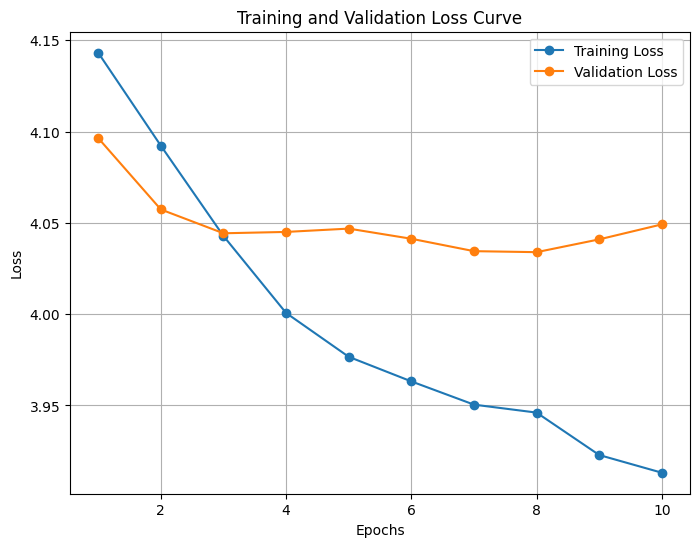

<All keys matched successfully>

In [49]:
# ------------------------------------------------------
# 1. Plot training and validation loss over epochs
# ------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# ------------------------------------------------------
# 2. Load best performing model (lowest validation loss)
# ------------------------------------------------------
best_model_cosine_mapper.load_state_dict(torch.load("best_model_cosine_mapper_trained_with_test.pth"))

The **training loss** (blue line) steadily decreases across the epochs, indicating that the model is learning and adapting well to the training data. In contrast, the **validation loss** (orange line) stabilizes relatively early—around epoch five and remains flat thereafter. This behavior suggests that the model is no longer improving its generalization ability on unseen data beyond that point.

The early stopping mechanism, based on a patience threshold, ensures that the model does not continue training unnecessarily, thus helping to avoid overfitting and reduce computational overhead.

Overall, the model demonstrates stable convergence with no indication of overfitting, making it well-prepared for deployment or further evaluation.


In [50]:
# ------------------------------------------------------
# 1. Load the best model (saved during training)
# ------------------------------------------------------
best_model_cosine_mapper.load_state_dict(torch.load("best_model_cosine_mapper_trained_with_test.pth"))
best_model_cosine_mapper.eval()
best_model_cosine_mapper.return_scores = False  # Only final predictions, no similarity scores

# ------------------------------------------------------
# 2. Run prediction loop on test set
# ------------------------------------------------------
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        texts = batch["text"]
        labels = batch["label"].tolist()

        preds = best_model_cosine_mapper.predict(texts)  # Predicted class indices
        print(labels)  # Optional: ground truth inspection
        print(preds)   # Optional: prediction inspection
        
        all_test_preds.extend(preds)
        all_test_labels.extend(labels)

# ------------------------------------------------------
# 3. Compute confusion matrix and prepare label list
# ------------------------------------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
all_labels = sorted(set(all_test_labels) | set(all_test_preds))  # Union of all seen labels

# ------------------------------------------------------
# 4. Create tabbed output for classification report and confusion matrix
# ------------------------------------------------------
tabs = []
titles = []

# Tab 0: Classification report
out0 = widgets.Output()
with out0:
    print(classification_report(all_test_labels, all_test_preds, digits=2))
tabs.append(out0)
titles.append("Classification Report")

# Tab 1: Confusion matrix heatmap
out1 = widgets.Output()
with out1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                xticklabels=all_labels, 
                yticklabels=all_labels)
    plt.title("Confusion Matrix: best_model_cosine_mapper_trained_with_test")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

tabs.append(out1)
titles.append("Confusion Matrix")

# ------------------------------------------------------
# 5. Display interactive results in tab layout
# ------------------------------------------------------
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)

[12, 1, 58, 3, 71, 24, 28, 63, 29, 35]
[45, 4, 13, 70, 72, 26, 28, 62, 29, 13]


### Evaluation on the Held-Out Test Set

Before drawing conclusions, it's important to emphasize that this evaluation is based on a **very limited test set**, just 15% of the total 64 manually labeled contract sections. This amounts to a **very small number of samples per class**, which severely limits the statistical significance and generalizability of the results.

Nevertheless, we proceeded with testing the fine-tuned `CosineMapper` model on this held-out set to demonstrate the functionality and setup. The **classification report and confusion matrix** were generated and are shown in the corresponding tab outputs.

Since only 10 classes were used for testing, the **informative value of the classification report is close to zero**. The evaluation results are heavily affected by the limited and unbalanced class distribution. Therefore, we deliberately **omit a detailed interpretation** at this point, as any insights drawn would be unreliable and not representative of real-world performance.

We are aware that meaningful model fine-tuning requires a significantly larger dataset, especially when aiming to distinguish between many classes. However, the setup used here was deliberately chosen to demonstrate the approach, and the code is structured to scale seamlessly as more labeled data becomes available. In the next step, we rerun the training without splitting off a separate test set in order to make better use of the limited labeled data during training and validation.

We acknowledge that training and evaluating with such limited data is not optimal, and we do not claim that the model is ready at this stage. Instead, this step serves as a proof of concept, demonstrating that the full code pipeline—from loading the model and generating embeddings to computing cosine similarity and evaluating predictions—works reliably end-to-end.

Due to the data limitations, we have decided that for the next steps, we will use the out-of-the-box pretrained model without further fine-tuning. This allows us to proceed with a stable and consistent foundation while keeping the door open for future improvement once more labeled data becomes available. We want to notice that the code is structured to seamlessly scale: once more labeled examples are added to the `sections_labeled_manually` table, **the entire process can be rerun** with minimal changes. This would almost certainly improve performance across all metrics.

To get a feeling of the effect of having more data available, we decided to **omit the test split entirely** and instead use a **larger portion of the data for validation** during training.  
This adjustment aims to increase the feedback signal available to the model and is especially helpful when working with few labeled examples.  
The results of this updated training run are presented at the end of this section.  
Since the training approach remains **exactly the same**, we will keep the description here brief.


We initialize a **new instance of the `CosineMapper` class**, using the **same parameters** as before.  
This ensures a fresh model state for the new training run, while keeping the architecture, pooling strategy, and label embeddings consistent with the previous setup.

In [51]:
# ------------------------------------------------------
# 1. Re-instantiate the CosineMapper after training
# ------------------------------------------------------
best_model_cosine_mapper = CosineMapper(
    model_name=url,                    # Pretrained model identifier
    label_embeddings=label_embeddings,  # Embedded catalogue label vectors
    pooling=pooling_strategy,           # Pooling strategy used in training
    threshold=threshold                 # Optimal cosine similarity threshold
)

We prepare the data in the **same way as before**, but this time we **omit the second split** that divided the validation data into separate validation and test sets.  
Instead, we **retain the full validation dataset** to provide the model with a **richer validation signal** during training.  
This setup helps improve learning stability when working with very few labeled examples.

In [52]:
# ------------------------------------------------------
# 1. Load manually labeled dataset and prepare label column
# ------------------------------------------------------
df = contract_sections_clean_labeled_manually.copy()

# Extract integer labels from catalog IDs
df["label"] = df["catalog_id"].astype(int)

# Convert texts and labels to lists for splitting
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()

# ------------------------------------------------------
# 2. Split into training and validation sets (70/30)
# ------------------------------------------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)

# ------------------------------------------------------
# 3. Create training DataLoader
# ------------------------------------------------------

train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

# Free memory
del train_texts, train_labels, train_dataset

# ------------------------------------------------------
# 4. Create validation DataLoader
# ------------------------------------------------------
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)

del val_texts, val_labels, val_dataset

We then run the training process again using the **larger validation dataset**, while keeping all other training parameters unchanged.  
By doing so, we aim to provide the model with a broader and more representative validation signal, which can help improve generalization — even in the absence of a separate test set.  
The updated training results are shown at the end of this section.

At this stage, we also experimented with different hyperparameters (e.g., learning rate, dropout, batch size, number of epochs).  
However, due to the **still limited amount of labeled data**, these adjustments did **not lead to significant improvements** over the out-of-the-box model.  

This reinforces our earlier insight: without a **larger and more diverse labeled dataset**, fine-tuning remains of limited value.  
As such, we continue using the pretrained model for the remainder of this project.


In [53]:
# ------------------------------------------------------
# 1. Training configuration and early stopping setup
# ------------------------------------------------------
epochs = 1000                      # Max number of epochs
patience = 10                      # Early stopping patience window
best_val_loss = float("inf")       # Initialize best validation loss
patience_counter = 0               # Counter for early stopping

# Optimizer and loss function
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Activate training mode and ensure model returns full score matrix
best_model_cosine_mapper.train()
best_model_cosine_mapper.return_scores = True

# Track training and validation loss history
train_losses = []
val_losses = []

# ------------------------------------------------------
# 2. Training loop with validation and early stopping
# ------------------------------------------------------
for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    # -------- Training Phase --------
    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] - 1  # Adjust label indexing to zero-based
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts) 
        loss = criterion(cos_sims, labels)
        train_total_loss += loss.item()

        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # -------- Validation Phase --------
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] - 1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break

# ------------------------------------------------------
# 3. Cleanup temporary variables to free memory
# ------------------------------------------------------
del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels

Epoch 1, Training Loss: 4.1543
Epoch 1, Validation Loss: 4.1190
--> Model saved!
Epoch 2, Training Loss: 4.0779
Epoch 2, Validation Loss: 4.0982
--> Model saved!
Epoch 3, Training Loss: 4.0524
Epoch 3, Validation Loss: 4.0929
--> Model saved!
Epoch 4, Training Loss: 4.0150
Epoch 4, Validation Loss: 4.0936
Epoch 5, Training Loss: 3.9793
Epoch 5, Validation Loss: 4.0950


KeyboardInterrupt: 

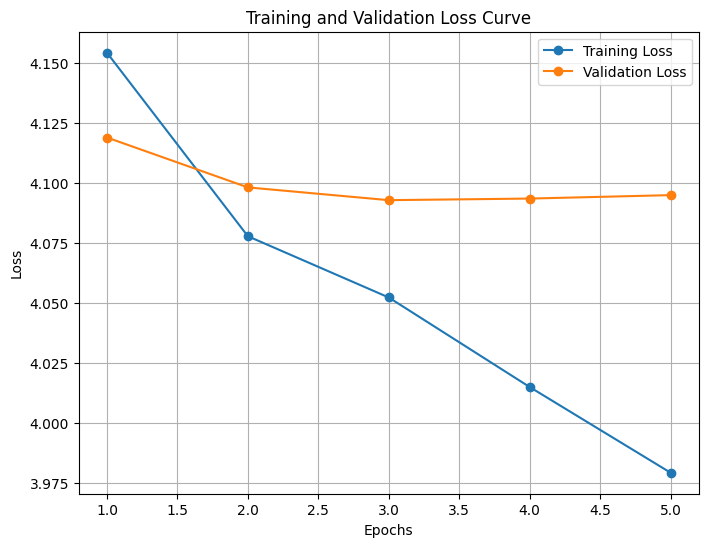

In [54]:
# ------------------------------------------------------
# Visualize loss progression during training
# ------------------------------------------------------
plt.figure(figsize=(8, 6))

# Plot training and validation loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# ------------------------------------------------------
# (Next Step) Reload best model after training if needed
# ------------------------------------------------------
# best_model_cosine_mapper.load_state_dict(torch.load("best_model_cosine_mapper_trained_with_test.pth"))


When comparing the two training runs—one using a traditional train/val/test split and the other using only a train/val split without a dedicated test set no definitive evidence of improved model performance can be claimed due to the limited dataset size.

However, the more stable and validation loss in the second run supports the assumption that **having more validation data provides a better training signal**. The differences, while not statistically significant, align with the hypothesis that **increasing the amount of labeled data—especially for validation—can help the model generalize better** and stabilize training in low-resource scenarios.

This observation reinforces the importance of **data availability** over parameter tuning at this stage.

# 6. Application + Textual checking of requirements

In the next step, we aim to demonstrate how our cosine-based mapper functions in practice. To do so, we will introduce an additional class designed to handle **end-to-end document processing**.

This new component will take an entire contract, **split it into meaningful sections**, and use the **CosineMapper** in combination with the **requirements catalog** to match each section to the most relevant requirement.

The goal is to move beyond individual predictions and enable a **real-world application**, where entire documents can be automatically analyzed and mapped to predefined criteria—creating a foundation for scalable and automated contract checking.


To demonstrate that our contract checker works in practice, we now apply it to a contract that has **not been used in training**. 

To achieve this, we first load the entire **contract corpus** and filter it down to only those contracts from which **none of the sections were used during labeling**. These contracts are stored in the `contracts_without_labels` dataset.

From this filtered set, we select one **example contract** to test the pipeline end-to-end. In this case, we use **Contract 16** as our evaluation example.


In [55]:
# ------------------------------------------------------
# 1. Load manually labeled contract sections
# ------------------------------------------------------
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx")
df = contract_sections_clean_labeled_manually.copy()

# ------------------------------------------------------
# 2. Load cleaned catalogue and assign catalog IDs
# ------------------------------------------------------
catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
# Optional preview:
# display(catalogue_clean.head(5))

# ------------------------------------------------------
# 3. Identify contracts that already have manual labels
# ------------------------------------------------------
df = df[pd.notna(df["contract"])]
contracts_with_labels = df["contract"].astype(int).unique()

# Cleanup temporary reference
del df, contract_sections_clean_labeled_manually

# ------------------------------------------------------
# 4. Load full set of contract contents
# ------------------------------------------------------
all_contracts = pd.read_pickle("../data/contract_contents_german_only")
df = all_contracts.copy()
df["contract"] = df["contract"].astype(int)

# ------------------------------------------------------
# 5. Identify contracts without manual labels
# ------------------------------------------------------
contracts_without_labels = df[~df["contract"].isin(contracts_with_labels)]["contract"].unique().tolist()

# ------------------------------------------------------
# 6. Extract one example contract for inspection
# ------------------------------------------------------
exp_contract = contracts_without_labels[0]
print(exp_contract)

exp = df[df["contract"] == exp_contract]  # Example: one random contract
display(exp)

# ------------------------------------------------------
# 7. Store all unlabeled contracts for downstream use
# ------------------------------------------------------
contract_sections_clean_without_labels = df[df["contract"].isin(contracts_without_labels)]

1


,contract,content
0,1,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...


### Initializing the Cosine Mapper with the Best Model (Untrained)

In the next step, we create a new instance of the `CosineMapper` class. As before, we use the parameters and model identified during the evaluation phase—specifically, the **best-performing model**, which in our case is **Multilingual Paraphrase (MiniLM-L12-v2)**.

This instance is named `best_model_cosine_mapper_untrained` to reflect the fact that we are using the **pretrained version directly from Hugging Face**, without any additional fine-tuning. This decision was made because our fine-tuning attempts did not yield significant improvements, primarily due to the limited amount of labeled data.


In [56]:
# ------------------------------------------------------
# 1. Load best model metadata from evaluation results
# ------------------------------------------------------
best_models = pd.read_pickle("../data/best_models.pkl")
best_model_info = best_models.iloc[0]

url              = best_model_info["model_url"]
pooling_strategy = best_model_info["pooling_strategy"]
threshold        = best_model_info["optimal_threshold"]

# ------------------------------------------------------
# 2. Generate embeddings for catalogue examples
# ------------------------------------------------------
catalogue_embeddings = add_embed_text_column(
    catalogue_clean,
    text_column="example",
    model=best_model,
    target_column="emb"
)

# Convert embeddings to PyTorch tensor
catalogue_embeddings_tensor = torch.tensor(
    np.stack(catalogue_embeddings["emb"].to_list())
).float()

# Store catalogue topics (optional for mapping later)
catalogue_topics = catalogue_clean["section_topic"]

# ------------------------------------------------------
# 3. Instantiate cosine-based classifier with frozen label embeddings
# ------------------------------------------------------
best_model_cosine_mapper_untrained = CosineMapper(
    model_name=url,
    label_embeddings=catalogue_embeddings_tensor,
    pooling=pooling_strategy,
    threshold=threshold
)

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


### Creating the Section Topic Predictor

We now use the `BestModelCosineMapperUntrained` instance to initialize a **Section Topic Predictor**. This new component takes the cosine mapper as input and uses the **requirement catalog topics** as target labels, which are referenced via their unique catalog IDs.

In practice, the model generates cosine similarity scores between the input section and all label embeddings (i.e., requirement examples). It then selects the ID with the **highest similarity** and looks up the corresponding **section topic** in the requirements catalog. The predicted topic is returned, optionally along with the similarity score for interpretability or confidence estimation.

In [57]:
topic_predictor = SectionTopicPredictor(best_model_cosine_mapper_untrained, catalogue_topics)

### Model performance: Predicting Topics for All Contract Sections

To showcase the model's capabilities, we now predict topics for all sections across all contracts. For each section, the model identifies the most relevant topic from the requirement catalog and records the top similarity scores of the best matches. 


In [58]:
# ------------------------------------------------------
# 1. Prepare containers for top predictions across contracts
# ------------------------------------------------------
top_scores = []
top_paragraphs = []
top_sections = []
top_indexes = []


# ------------------------------------------------------
# 2. Loop through all contracts without manual labels
# ------------------------------------------------------
for i in contracts_without_labels:
    # Extract full contract text by ID
    contract = contract_sections_clean_without_labels.loc[
        contract_sections_clean_without_labels["contract"] == i, "content"
    ].iloc[0]

    # Run topic predictor to classify contract sections
    df = topic_predictor.predict_contract(contract, return_topic_score=True)

    # Sort predictions by highest score
    df = df.sort_values("score", ascending=False)

    # Extract top match data for this contract
    top_score = df.iloc[0]["score"]
    top_paragraph = df.iloc[0]["paragraph"]
    top_section = df.iloc[0]["section"]
    index_topscore = df[df["section"] == top_section].index[0]  # Get original index

    # Append top prediction results
    top_scores.append(top_score)  
    top_paragraphs.append(top_paragraph)
    top_sections.append(top_section)  
    top_indexes.append(index_topscore)  


del i, df, contract, top_score, top_section, index_topscore

These results are then stored in a table for comparison. As shown in the output below, the highest top score achieved is 0.65, while the lowest top match score is 0.2307.

In [59]:
df_top_predictions = pd.DataFrame({
    "contract": contracts_without_labels,
    "prargaph": top_paragraphs,
    "section": top_sections,
    "score": top_scores,
    "index": top_indexes
})

display(df_top_predictions.sort_values("score", ascending= False))

,contract,prargaph,section,score,index
5,16,14.,14.2,0.7158,40
1,3,1.,1.5,0.5710,4
4,15,§ 3,3.2,0.5483,10
0,1,§ 1,1.1,0.4562,0
2,9,1.,1.1,0.4336,0
3,10,§ 1,(1),0.2319,0


In the following step, we take a closer look at how our system performs on a real-world example. For this purpose, we again focus on **Contract 16**, which we had previously selected as a representative sample.

We begin by extracting the full raw text of this contract from the `content` column of our dataset and pass it into the `topic_predictor` instance. 

By setting `return_topic_score=True`, we ensure that the model outputs not just the predicted topic but also the associated cosine similarity score. This allows us to assess the confidence of each prediction.

For example, Section 39 of the contract might yield the following result:




In [60]:
# ------------------------------------------------------
# 1. Select a specific contract from the unlabeled pool
# ------------------------------------------------------
df = contract_sections_clean_without_labels.copy()
exp = df[df["contract"] == 16]  # Example: contract ID 16

# ------------------------------------------------------
# 2. Predict topics for all sections in the selected contract
# ------------------------------------------------------
text = exp["content"].values[0]
df = topic_predictor.predict_contract(text, return_topic_score=True)

# ------------------------------------------------------
# 3. Choose a specific section for inspection (e.g., section 39)
# ------------------------------------------------------
exp_section = 39  # Can be chosen manually or via random.randint(...)

# Extract top prediction info for the chosen section
topic   = df.loc[exp_section, "predicted_topic"]
content = df.loc[exp_section, "section_content"]
score   = df.loc[exp_section, "score"]

# ------------------------------------------------------
# 4. Display the predicted topic, section content, and confidence score
# ------------------------------------------------------
print("? Predicted Topic:\n", topic)
print("! Section Content:\n", content)
print("\033[92m🔥 Score:\033[0m", score)  # Highlight score in green

# ------------------------------------------------------
# 5. Save the full prediction dataframe for further analysis
# ------------------------------------------------------
labeled_sections_example_contract = df.copy()

# Cleanup temporary variables
del df, exp, text, exp_section, topic, content, score

? Predicted Topic:
 Gibt es einen formalen Prozess für Leistungsänderungen während des Projekts (Change Request)?
! Section Content:
 14.1 Diese Vereinbarung und ihre Änderungen sowie alle vertragsrelevanten Erklärungen, Mitteilungs- und Dokumentationsp#ichten bedürfen der Schriftform, soweit nicht eine andere Form vereinbart oder gesetzlich vorgeschrieben ist.
🔥 Score: 0.5428


This indicates a quite valid match between the contract section and the corresponding item in the requirement catalog.

For further processing, we save the labeled and matched output of the full contract into a new dataset named `labeled_sections_example_contract`. This dataset contains all sections of the selected contract (Contract 16), each annotated with its predicted topic from the requirement catalog along with the corresponding cosine similarity score.

The following table shows the current structure of the output generated by the contract mapping process. Each row represents one section of the selected contract, enriched with metadata and prediction results:

In [61]:
df = labeled_sections_example_contract.copy()
display(df.head(5))
scores = df.sort_values("score")

,contract,paragraph,paragraph_content,section,section_content,clean_section_content,predicted_topic,score
0,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,diese vertragsbedingungen gelten für die nutzu...,Werden geplante Schnittstellen zu Dritt-System...,0.4830
1,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,die software wird vom anbieter als saas bzw cl...,"Hat der Kunde das Recht, die Einhaltung der Si...",0.4847
2,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,diese vertragsbedingungen gelten ausschließlic...,Sind die Rechte des Kunden im Gewährleistungsf...,0.5176
3,1,2.,2. Art und Umfang der Leistung Der Anbieter st...,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,art und umfang der leistung der anbieter stell...,"Sind ausdrücklich Leistungen benannt, die nich...",0.4782
4,1,3.,3. Verfügbarkeit der Software 3.1 Der Anbieter...,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...",der anbieter weist den kunden darauf hin dass ...,"Wird geregelt, wem neu entstehende Arbeitserge...",0.5805


One can understand the column **predicted topic** as a **question**, and the corresponding **section content** as its **answer**. This analogy helps to understand the nature of the semantic mapping process:

The model identifies which **requirement (topic)** a section most closely addresses.
The **cosine similarity score** in the last column expresses **how well the section semantically aligns** with the example section for that topic in the requirements catalog.

The higher the score, the more confidently the model associates the section with that particular requirement.

The following table illustrates this interpretation by listing sections, its predicted topic, and the associated mapping score.

In [62]:
display(df[["predicted_topic","section_content","score"]].head(5))
del df

,predicted_topic,section_content,score
0,Werden geplante Schnittstellen zu Dritt-System...,1.1 Diese Vertragsbedingungen gelten für die N...,0.4830
1,"Hat der Kunde das Recht, die Einhaltung der Si...",1.2 Die Software wird vom Anbieter als SaaS- b...,0.4847
2,Sind die Rechte des Kunden im Gewährleistungsf...,1.3 Diese Vertragsbedingungen gelten ausschlie...,0.5176
3,"Sind ausdrücklich Leistungen benannt, die nich...",2. Art und Umfang der Leistung Der Anbieter st...,0.4782
4,"Wird geregelt, wem neu entstehende Arbeitserge...","3.1 Der Anbieter weist den Kunden darauf hin, ...",0.5805


# 7. Evaluate Contract Sections
In this section, we assess how well individual contract sections satisfy the core aspects by applying a structured evaluation using a large language model (LLM). Each section is matched to a relevant topic from the requirement catalog, which in turn defines the expected checklist of core aspects that should be addressed in the text.

To measure how well these expectations are fulfilled, we use the GPT-4o-mini model to systematically score each section. The LLM receives a structured prompt that contains the section text and its associated core aspects, and returns both individual scores for each aspect and an overall average fulfillment percentage.

This allows us to quantitatively evaluate coverage and completeness for each section, enabling scalable and interpretable quality control in the contract checking process.

## 7.1 Initialize OpenAI Client

Before sending any prompts to the language model, we initialize the OpenAI API client using our predefined API key (`OpenAiKey`). This client will be used throughout the evaluation process to communicate with the GPT-4o-mini model and retrieve responses for scoring contract sections.


In [63]:
client = OpenAI(api_key=OpenAiKey)

## 7.2 Prepare Labeled Sections with Core Aspects

In this step, we enrich the manually labeled contract sections with the corresponding core aspects needed for evaluation. This includes loading the cleaned catalogue, merging it into the labeled sections based on predicted topics, and preparing the relevant columns for downstream processing.

The merged result provides a structured dataset where each section now includes the original section content, its predicted topic and the manually defined core aspects for that topic.

This forms the basis for the upcoming LLM-based scoring and evaluation. A backup of the resulting DataFrame is also created for later use.


In [64]:
# ------------------------------------------------------------------
# 1. Load data and merge core aspects into labeled section dataframe
# ------------------------------------------------------------------

# Create a copy of the labeled sections to work with
df = labeled_sections_example_contract.copy()

# Load the clean catalogue containing the manually defined core aspects
catalogue_clean_with_aspects = pd.read_excel("../data/catalogue_clean_with_aspects.xlsx")

# Merge the core aspects into the section dataframe based on matching topics
df = df.merge(
    catalogue_clean_with_aspects[["section_topic", "core_aspects"]],
    left_on="predicted_topic",
    right_on="section_topic",
    how="left")

# Select only relevant columns for further evaluation
df = df[["contract", "paragraph", "section", "section_content", "predicted_topic", "score", "core_aspects"]]

# Preview the first few rows of the result
display(df.head(5))

# Create a backup copy for further evaluation steps
labeled_sections_example_contract_with_critertia = df.copy()

# Free memory by removing unused variables
del df, catalogue_clean_with_aspects

,contract,paragraph,section,section_content,predicted_topic,score,core_aspects
0,1,1.,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,Werden geplante Schnittstellen zu Dritt-System...,0.4830,Eine Meldepflicht bei Terminverzögerungen ist ...
1,1,1.,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,"Hat der Kunde das Recht, die Einhaltung der Si...",0.4847,Kunde hat vertraglich geregeltes Recht auf Nac...
2,1,1.,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,Sind die Rechte des Kunden im Gewährleistungsf...,0.5176,Die Rechte des Kunden im Gewährleistungsfall s...
3,1,2.,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,"Sind ausdrücklich Leistungen benannt, die nich...",0.4782,Kundenseitige Mitwirkungspflichten sind konkre...
4,1,3.,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...","Wird geregelt, wem neu entstehende Arbeitserge...",0.5805,Eigentumsrechte an individuell entwickelten Ar...


## 7.3 Evaluate Sections with LLM and Extract Fulfillment Scores

After preparing the contract sections with their corresponding core aspects, we now use an LLM (GPT-4o-mini) to evaluate how well each section fulfills its assigned requirements.

Each section is passed to the `evaluate_fullfillment_on_criteria()` function, which sends the content and list of core aspects to the LLM. The model responds with a JSON object containing a score for each individual core aspect, and an overall fulfillment percentage.

We then extract the relevant information from the returned JSON structure into separate columns for further analysis: `core_aspect_scores`, which is a dictionary mapping each core aspect to its individual fulfillment score, and `average_fulfillment_percent`, which represents the overall average score across all aspects.

Finally, the enriched and evaluated dataset is stored in both `.pkl` and `.xlsx` formats to support future downstream tasks.


In [65]:
# ------------------------------------------------------------------
# 2. Run LLM-based evaluation on each contract section using core aspects
# ------------------------------------------------------------------

# Create a copy of the prepared contract sections with associated core aspects
df = labeled_sections_example_contract_with_critertia.copy()

# Apply the evaluation function to each row using the LLM
# The function checks how well the section content fulfills the given criteria
df["llm_eval_result"] = df.apply(lambda x: evaluate_fullfillment_on_criteria(x
                                                                            , model = "gpt-4o-mini"
                                                                            , content_column ="section_content"
                                                                            , criteria_column="core_aspects"
                                                                            , client=client)
                                                                            , axis=1)

# Store the raw LLM result again (technically redundant in this case)
df.loc[df.index, "llm_eval_result"] = df["llm_eval_result"]

# Extract detailed core aspect scores from the LLM results
df["core_aspect_scores"] = df["llm_eval_result"].apply(
    lambda x: x.get("core_aspect_scores", {}) if isinstance(x, dict) else {}
)

# Extract overall average fulfillment percentage
df["average_fulfillment_percent"] = df["llm_eval_result"].apply(
    lambda x: x.get("average_fulfillment_percent") if isinstance(x, dict) else None
)

# ------------------------------------------------------------------
# 3. Save the evaluated contract sections for further analysis
# ------------------------------------------------------------------

# Save final result to both pickle and Excel formats
example_contract_labeld_and_evaluated = df.copy()
example_contract_labeld_and_evaluated .to_pickle("../data/example_contract_labeld_and_evaluated.pkl")
example_contract_labeld_and_evaluated .to_excel("../data/example_contract_labeld_and_evaluated..xlsx", index=False)

# Clean up to free memory
del df


✅ LLM response: {
    "core_aspect_scores": {
        "Eine Meldepflicht bei Terminverzögerungen ist geregelt": 0,
        "Die Gründe für die Verzögerung müssen genannt werden": 0,
        "Ein neuer Projektplan wird gemeinsam erstellt": 0,
        "Vertragsstrafen bei schuldhaftem Verzug sind benannt": 0,
        "Höhe, Bedingungen und Obergrenzen sind konkret definiert": 0
    },
    "average_fulfillment_percent": 0
}
✅ LLM response: {
    "core_aspect_scores": {
        "Kunde hat vertraglich geregeltes Recht auf Nachweis der Sicherheitsmaßnahmen": 0,
        "Nachweis kann durch aktuelle Prüfzertifikate (z. B. ISO 27001) erbracht werden": 0,
        "Alternativ sind Prüfberichte unabhängiger Auditoren zulässig": 0,
        "Kunde oder ein beauftragter Dritter darf Audit vor Ort durchführen": 0,
        "Audit ist einmal jährlich möglich, mit vorheriger Ankündigung und zu üblichen Geschäftszeiten": 0
    },
    "average_fulfillment_percent": 0
}
✅ LLM response: {
    "core_aspect_s

KeyboardInterrupt: 

# 7.4 Visual inspection of one evaluated contract section
To better understand the results of the LLM-based evaluation, we take a closer look at one example contract section that received a valid fulfillment score. We first filter the evaluated dataset to include only rows with a non-null average_fulfillment_percent and sort it by the highest score.

From the resulting subset, we select the second-highest scoring section and present a detailed preview. This interface shows the original section content, the predicted topic it was mapped to, the associated core aspects, the individual aspect-level fulfillment scores, and the overall average fulfillment percentage.

In [66]:
# ------------------------------------------------------------------
# 4. Inspect one evaluated contract section in detail 
# ------------------------------------------------------------------

# Create a copy of the evaluated contract DataFrame
df = example_contract_labeld_and_evaluated.copy()

# Filter for rows that contain a valid fulfillment score, sort by highest score
df = df[df["average_fulfillment_percent"].notnull()].sort_values("average_fulfillment_percent", ascending=False).head()
display(df)

# Helper function: inserts line breaks every n characters to improve readability
def insert_linebreaks_every_n_chars(text, n=100):
    return '\n'.join(text[i:i+n] for i in range(0, len(text), n))

# If at least one row is available, display selected fields in a tabbed widget
if not df.empty:
	first_row = df.iloc[1]

	tabs = []
	titles = []

	# Tab 1: Show full section content (wrapped)
	out0 = widgets.Output()
	with out0:
		print(insert_linebreaks_every_n_chars(first_row["section_content"], n=200))
	tabs.append(out0)
	titles.append("section content")

	# Tab 2: Show the predicted topic this section was mapped to
	out1 = widgets.Output()
	with out1:
		print(f'mapped to : {first_row["predicted_topic"]}')
	tabs.append(out1)
	titles.append("topic")

	# Tab 3: Show all relevant core aspects for this section (line-separated)
	out2 = widgets.Output()
	with out2:
		print(f'{first_row["core_aspects"]}'.replace(",",",\n"))
	tabs.append(out2)
	titles.append("core aspecs")

	# Tab 4: Show the individual fulfillment scores per aspect
	out3 = widgets.Output()
	with out3:
		print(f'{first_row["core_aspect_scores"]}')
	tabs.append(out3)
	titles.append("single scores")

	# Tab 5: Show the average fulfillment percentage
	out4 = widgets.Output()
	with out4:
		print(f'average fulfillment percent: {first_row["average_fulfillment_percent"]}%')   
	tabs.append(out4)
	titles.append("avg score")

	# Combine all outputs into one tab view
	tab_widget = widgets.Tab(children=tabs)
	for i, title in enumerate(titles):
		tab_widget.set_title(i, title)

	display(tab_widget)


NameError: name 'example_contract_labeld_and_evaluated' is not defined

## 8. Outlook and Next Steps

While the current system demonstrates solid foundations—including a clause-matching pipeline, LLM-based scoring, and an extensible structure—there are several technical, methodological, and user-facing developments that can greatly enhance the tool’s effectiveness and robustness. Below, we outline the key next steps and areas for improvement:

### 8.1. Expand the Clause Catalogue and Prompt Set

At the heart of the scoring process lies a curated catalogue of core aspects—each representing a contractual requirement such as data protection, liability limitations, or termination rights. Currently, these core aspects are generated via prompts manually. To improve consistency and coverage, the following should be considered:

- **Expert-Curated evaluation**: Collaborate with legal professionals to ensure that core aspect prompt outputs are precise and correct.
- **Add More Examples**: Enrich each core aspect with example clauses, both positive (compliant) and negative (non-compliant), to give models more grounding.

### 8.2. Integrate Feedback Loops and Expert Review

A crucial step toward production-readiness is the inclusion of expert review to validate and calibrate the tool’s assessments. This includes:

- **Expert Evaluation of GPT Scores**: Have legal professionals verify whether high GPT fulfillment scores truly reflect legal adequacy.
- **Error Analysis**: Examine false positives and false negatives to improve prompt design and model behavior.
- **Feedback-Guided Fine-Tuning**: fine-tune a model on a curated, expert-labeled dataset to improve domain specificity.

### 8.3. Detect Anomalies and Suspicious Matches

Not all clause matches are trustworthy. Despite good semantic similarity, LLMs may confidently score irrelevant or loosely related content. Right now we match every aspect in the requirement catalogue, even if the model is not very certain. We do that because we believe that a bad match is better than no match, since every match should be reviewed by a human afterwards anyways. Suggested improvements:

- **Outlier Detection Logic**: Flag low-confidence or inconsistent matches for additional review.
- **Similarity Thresholds**: Introduce minimum cosine similarity thresholds to reduce noise in paragraph matching. (this requires a better trained mode e.g. more data)

### 8.4. Merge Pipeline Logic into Unified Components

Currently, the system operates as a Jupyter notebook. For modularity and scalability:

- **Introduce a `ContractChecker` Class**: Encapsulate key steps—input parsing, section mapping, scoring, and aggregation—into a single, reusable Python class.
- **Wrap the Pipeline into a Service**: Develop the architecture as a callable backend service to support frontend integration.

### 8.5. Benchmark and Compare More LLMs

Our current prototype relies on OpenAI's GPT-4, which may not be optimal in every aspect. The following actions are recommended:

- **Compare Alternative LLMs**: Evaluate Claude 3, Gemini 1.5, Mistral, and open-source models for cost, latency, and interpretability.
- **Latency and Cost Trade-Offs**: Consider model selection based on batch vs. real-time needs.
- **Check for Model Bias**: Audit whether certain models over- or under-score based on stylistic differences in legal language.

### 8.7. Deploy a User-Facing Interface

The full utility of the system depends on ease of access and clarity for end-users. Building on the frontend prototype:

- **Streamlit or Flask App**: Offer drag-and-drop uploads, section-wise results, and downloadable summaries.
- **Interactive Highlighting**: Let users inspect failed aspects and view the responsible text fragments directly.
- **User Feedback Loop**: Provide mechanisms for users to report scoring inaccuracies and integrate feedback into future iterations.

## 9. Conclusion

This project demonstrates the potential of combining structured legal knowledge with advanced natural language models to build a smart, explainable contract review assistant. The current pipeline—from clause extraction to LLM-based evaluation—offers a proof of concept that is already functional and extensible. You can simply add additional documents at the beginning of our pipeline and get them evaluated.

However, true deployment will require rigorous validation, broader model experimentation, more training data, and involvement of legal professionals. Usability improvements such as interface development and expert feedback integration will determine the system’s real-world adoption.

In sum, the project lays the groundwork for a hybrid review system where human expertise is augmented—not replaced—by intelligent tooling. Continued development along the proposed lines can elevate this prototype into a practical and reliable assistant in legal operations, particularly for organizations handling a high volume of standardized contracts.